In [145]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import math
from IPython.display import display, Markdown
import scipy.stats as stats

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Decide between local or kaggle cloud storage         
KAGGLE_ENV = 'kaggle' in os.listdir('/')
data_path = '/kaggle/input' if KAGGLE_ENV else '../kaggle/input'
    
    
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        print(os.path.join(dirname, filename)) 

../kaggle/input/submission.csv
../kaggle/input/s4-e11-train-concat-final.csv
../kaggle/input/depression-surveydataset-for-analysis/final_depression_dataset_1.csv
../kaggle/input/playground-series-s4e11/sample_submission.csv
../kaggle/input/playground-series-s4e11/test.csv
../kaggle/input/playground-series-s4e11/train.csv
../kaggle/input/s4-e11-test-concat/s4-e11-test-concat.csv
../kaggle/input/s4-e11-train-concat-final/s4-e11-train-concat-final.csv
../kaggle/input/s4-e11-train-concat-final/dataset-metadata.json
../kaggle/input/s4-e11-train-concat/s4-e11-train-concat.csv
../kaggle/input/s4-e11-test-concat-final/s4-e11-test-concat-final.csv


In [146]:
def merge_rare_categories(df, feature, threshold):
    value_counts = df[feature].value_counts()

    to_remove = value_counts[value_counts < threshold].index
    print(to_remove)

    # Replace the data cell with NaN
    df[feature] = df[feature].apply(lambda x: x if x not in to_remove else None)

    print(df.head(25))
    return df

In [147]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [148]:
def plot_heatmap(df, feature, target):
    # Absolute values calculation (number of cases per feature and target)
    degree_dep_table = pd.crosstab(df[feature], df[target])

    # Check if target has only two categories (e.g., binary classification)
    if len(degree_dep_table.columns) == 2:
        # Sort rows by the number of cases where target = 1 (depression cases)
        degree_dep_table = degree_dep_table.sort_values(by=1, ascending=False)

    # Relative values calculation (row-wise normalization to get percentage values)
    degree_dep_table_rel = degree_dep_table.div(degree_dep_table.sum(axis=1), axis=0) * 100

    # Ensure that the sorting is applied to both tables
    degree_dep_table_rel = degree_dep_table_rel.loc[degree_dep_table.index]

    # Combined display: Absolute values + percentage values in one cell
    combined_table = degree_dep_table.astype(str) + " (" + degree_dep_table_rel.round(2).astype(str) + "%)"

    # Plot heatmap
    plt.figure(figsize=(35, 12))
    sns.heatmap(degree_dep_table_rel, annot=combined_table, fmt="", cmap="coolwarm")
    plt.title(f"{target} Distribution by {feature} (Sorted by Highest {target} Cases)")
    plt.show()

# Intoduction

In this exploratory data analysis (EDA), we aim to gain a deeper understanding of the dataset by performing the following key steps:

- Understand the structure of the data: Identify data types, feature distributions, and basic statistics.
- Explore patterns and relationships: Examine correlations, feature interactions, and potential trends.
- Detect missing values: Identify incomplete data and evaluate possible imputation strategies.
- Identify outliers: Locate extreme values that may impact model performance or require transformation.

This analysis will provide valuable insights to guide further data preprocessing and modeling decisions.

# Load Data

In [149]:
# Load the data
train_original = pd.read_csv(data_path + '/playground-series-s4e11/train.csv')
test_original = pd.read_csv(data_path + '/playground-series-s4e11/test.csv')
sample_submission = pd.read_csv(data_path + '/playground-series-s4e11/sample_submission.csv')
original_data = pd.read_csv(data_path + '/depression-surveydataset-for-analysis/final_depression_dataset_1.csv')

# Quick Overview

In [150]:
train_original.head()

id      Name  Gender   Age           City Working Professional or Student  \
0   0  Aaradhya  Female  49.0       Ludhiana            Working Professional   
1   1     Vivan    Male  26.0       Varanasi            Working Professional   
2   2    Yuvraj    Male  33.0  Visakhapatnam                         Student   
3   3    Yuvraj    Male  22.0         Mumbai            Working Professional   
4   4      Rhea  Female  30.0         Kanpur            Working Professional   

         Profession  Academic Pressure  Work Pressure  CGPA  \
0              Chef                NaN            5.0   NaN   
1           Teacher                NaN            4.0   NaN   
2               NaN                5.0            NaN  8.97   
3           Teacher                NaN            5.0   NaN   
4  Business Analyst                NaN            1.0   NaN   

   Study Satisfaction  Job Satisfaction     Sleep Duration Dietary Habits  \
0                 NaN               2.0  More than 8 hours        Healthy   
1                 NaN               3.0  Less than 5 hours      Unhealthy   
2                 2.0               NaN          5-6 hours        Healthy   
3                 NaN               1.0  Less than 5 hours       Moderate   
4                 NaN               1.0          5-6 hours      Unhealthy   

    Degree Have you ever had suicidal thoughts ?  Work/Study Hours  \
0      BHM                                    No               1.0   
1      LLB                                   Yes               7.0   
2  B.Pharm                                   Yes               3.0   
3      BBA                                   Yes              10.0   
4      BBA                                   Yes               9.0   

   Financial Stress Family History of Mental Illness  Depression  
0               2.0                               No           0  
1               3.0                               No           1  
2               1.0                               No           1  
3               1.0                              Yes           1  
4               4.0                              Yes           0

In [151]:
test_original.head()

id     Name  Gender   Age           City  \
0  140700   Shivam    Male  53.0  Visakhapatnam   
1  140701    Sanya  Female  58.0        Kolkata   
2  140702     Yash    Male  53.0         Jaipur   
3  140703   Nalini  Female  23.0         Rajkot   
4  140704  Shaurya    Male  47.0         Kalyan   

  Working Professional or Student              Profession  Academic Pressure  \
0            Working Professional                   Judge                NaN   
1            Working Professional  Educational Consultant                NaN   
2            Working Professional                 Teacher                NaN   
3                         Student                     NaN                5.0   
4            Working Professional                 Teacher                NaN   

   Work Pressure  CGPA  Study Satisfaction  Job Satisfaction  \
0            2.0   NaN                 NaN               5.0   
1            2.0   NaN                 NaN               4.0   
2            4.0   NaN                 NaN               1.0   
3            NaN  6.84                 1.0               NaN   
4            5.0   NaN                 NaN               5.0   

      Sleep Duration Dietary Habits  Degree  \
0  Less than 5 hours       Moderate     LLB   
1  Less than 5 hours       Moderate    B.Ed   
2          7-8 hours       Moderate  B.Arch   
3  More than 8 hours       Moderate     BSc   
4          7-8 hours       Moderate     BCA   

  Have you ever had suicidal thoughts ?  Work/Study Hours  Financial Stress  \
0                                    No               9.0               3.0   
1                                    No               6.0               4.0   
2                                   Yes              12.0               4.0   
3                                   Yes              10.0               4.0   
4                                   Yes               3.0               4.0   

  Family History of Mental Illness  
0                              Yes  
1                               No  
2                               No  
3                               No  
4                               No

In [152]:
original_data.head()

Name  Gender  Age       City Working Professional or Student  \
0    Pooja  Female   37  Ghaziabad            Working Professional   
1  Reyansh    Male   60     Kalyan            Working Professional   
2    Manvi  Female   42     Bhopal            Working Professional   
3     Isha  Female   44      Thane            Working Professional   
4    Aarav    Male   48     Indore            Working Professional   

          Profession  Academic Pressure  Work Pressure  CGPA  \
0            Teacher                NaN            2.0   NaN   
1  Financial Analyst                NaN            4.0   NaN   
2            Teacher                NaN            2.0   NaN   
3            Teacher                NaN            3.0   NaN   
4     UX/UI Designer                NaN            4.0   NaN   

   Study Satisfaction  Job Satisfaction Sleep Duration Dietary Habits Degree  \
0                 NaN               4.0      7-8 hours       Moderate     MA   
1                 NaN               3.0      5-6 hours      Unhealthy  B.Com   
2                 NaN               3.0      5-6 hours       Moderate  M.Com   
3                 NaN               5.0      7-8 hours        Healthy     MD   
4                 NaN               3.0      7-8 hours       Moderate     BE   

  Have you ever had suicidal thoughts ?  Work/Study Hours  Financial Stress  \
0                                    No                 6                 2   
1                                   Yes                 0                 4   
2                                    No                 0                 2   
3                                   Yes                 1                 2   
4                                   Yes                 6                 5   

  Family History of Mental Illness Depression  
0                               No         No  
1                              Yes         No  
2                               No         No  
3                              Yes         No  
4                              Yes         No

In [153]:
sample_submission.head()

id  Depression
0  140700           0
1  140701           0
2  140702           0
3  140703           0
4  140704           0

In [154]:
original_data.head()

Name  Gender  Age       City Working Professional or Student  \
0    Pooja  Female   37  Ghaziabad            Working Professional   
1  Reyansh    Male   60     Kalyan            Working Professional   
2    Manvi  Female   42     Bhopal            Working Professional   
3     Isha  Female   44      Thane            Working Professional   
4    Aarav    Male   48     Indore            Working Professional   

          Profession  Academic Pressure  Work Pressure  CGPA  \
0            Teacher                NaN            2.0   NaN   
1  Financial Analyst                NaN            4.0   NaN   
2            Teacher                NaN            2.0   NaN   
3            Teacher                NaN            3.0   NaN   
4     UX/UI Designer                NaN            4.0   NaN   

   Study Satisfaction  Job Satisfaction Sleep Duration Dietary Habits Degree  \
0                 NaN               4.0      7-8 hours       Moderate     MA   
1                 NaN               3.0      5-6 hours      Unhealthy  B.Com   
2                 NaN               3.0      5-6 hours       Moderate  M.Com   
3                 NaN               5.0      7-8 hours        Healthy     MD   
4                 NaN               3.0      7-8 hours       Moderate     BE   

  Have you ever had suicidal thoughts ?  Work/Study Hours  Financial Stress  \
0                                    No                 6                 2   
1                                   Yes                 0                 4   
2                                    No                 0                 2   
3                                   Yes                 1                 2   
4                                   Yes                 6                 5   

  Family History of Mental Illness Depression  
0                               No         No  
1                              Yes         No  
2                               No         No  
3                              Yes         No  
4                              Yes         No

# Overview

In [155]:
def data_overview(data, target):
    # Overview
    display(Markdown("## Data Overview"))
    
    display(Markdown("### General Information"))
    display(Markdown(f"- Number of rows and columns: {data.shape[0]} x {data.shape[1]}"))
    display(Markdown("- Column names:"))
    display(list(data.columns))

    display(Markdown("### Data Types & Missing Values"))
    missing = data.isnull().sum()
    dtypes = pd.DataFrame(data.dtypes, columns=["Data Type"])
    missing_df = pd.DataFrame(missing, columns=["Missing Values"])
    overview_df = dtypes.join(missing_df)
    display(overview_df.style.background_gradient(cmap="coolwarm"))

    display(Markdown("### Classic head of Data"))
    display(data.head().style.set_properties(**{"background-color": "#f5f5f5"}))

    display(Markdown("### Statistical Summary (describe)"))
    display(data.describe().T.style.background_gradient(cmap="viridis"))

    # Target variable analysis
    display(Markdown(f"## Target Variable: `{target}`"))
    sns.set_style("whitegrid")  
    sns.set_palette("viridis")   

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Absolute frequency barplot
    sns.barplot(x=data[target].value_counts().index, 
                y=data[target].value_counts(), 
                ax=ax[0])  

    ax[0].set_title("Absolute Frequency", fontsize=12, fontweight="bold")
    ax[0].set_ylabel("Count")
    ax[0].set_xlabel(target)
    ax[0].grid(axis="y", linestyle="--", alpha=0.5)  

    # Percentage distribution barplot
    sns.barplot(x=data[target].value_counts().index, 
                y=data[target].value_counts(normalize=True), 
                ax=ax[1])  

    ax[1].set_title("Percentage Distribution", fontsize=12, fontweight="bold")
    ax[1].set_ylabel("Percentage")
    ax[1].set_xlabel(target)
    ax[1].grid(axis="y", linestyle="--", alpha=0.5)

    

    for spine in ["top", "right"]:
        ax[0].spines[spine].set_visible(False)
        ax[1].spines[spine].set_visible(False)

    plt.tight_layout()
    plt.show()

## Data Overview

### General Information

- Number of rows and columns: 2556 x 19

- Column names:

['Name',
 'Gender',
 'Age',
 'City',
 'Working Professional or Student',
 'Profession',
 'Academic Pressure',
 'Work Pressure',
 'CGPA',
 'Study Satisfaction',
 'Job Satisfaction',
 'Sleep Duration',
 'Dietary Habits',
 'Degree',
 'Have you ever had suicidal thoughts ?',
 'Work/Study Hours',
 'Financial Stress',
 'Family History of Mental Illness',
 'Depression']

### Data Types & Missing Values

### Classic head of Data

### Statistical Summary (describe)

## Target Variable: `Depression`

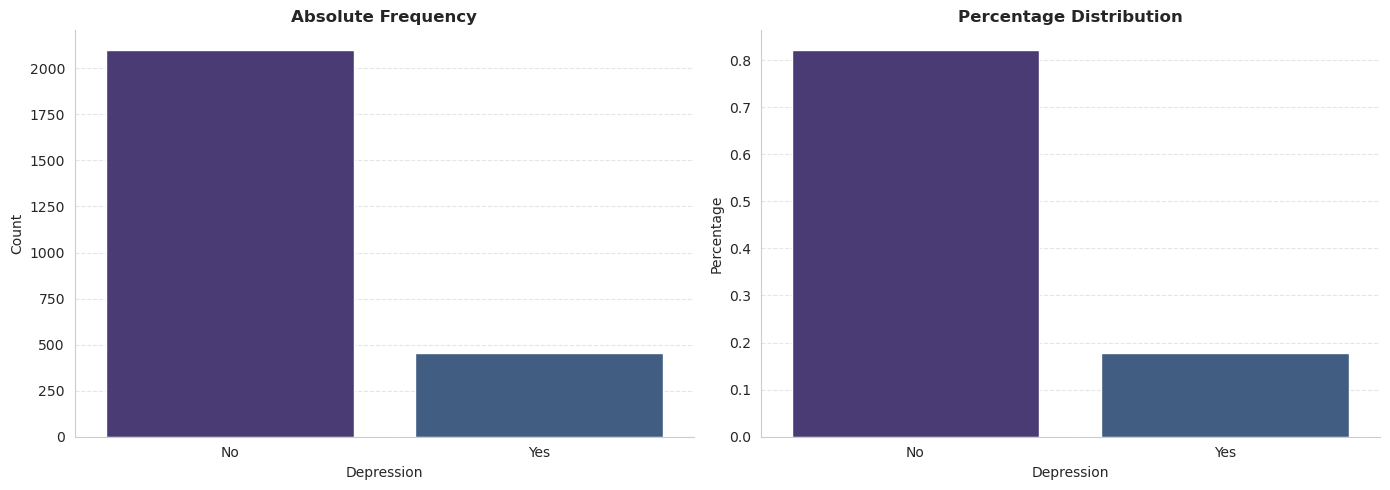

In [156]:
data_overview(original_data, 'Depression')

## Data Overview

### General Information

- Number of rows and columns: 140700 x 20

- Column names:

['id',
 'Name',
 'Gender',
 'Age',
 'City',
 'Working Professional or Student',
 'Profession',
 'Academic Pressure',
 'Work Pressure',
 'CGPA',
 'Study Satisfaction',
 'Job Satisfaction',
 'Sleep Duration',
 'Dietary Habits',
 'Degree',
 'Have you ever had suicidal thoughts ?',
 'Work/Study Hours',
 'Financial Stress',
 'Family History of Mental Illness',
 'Depression']

### Data Types & Missing Values

### Classic head of Data

### Statistical Summary (describe)

## Target Variable: `Depression`

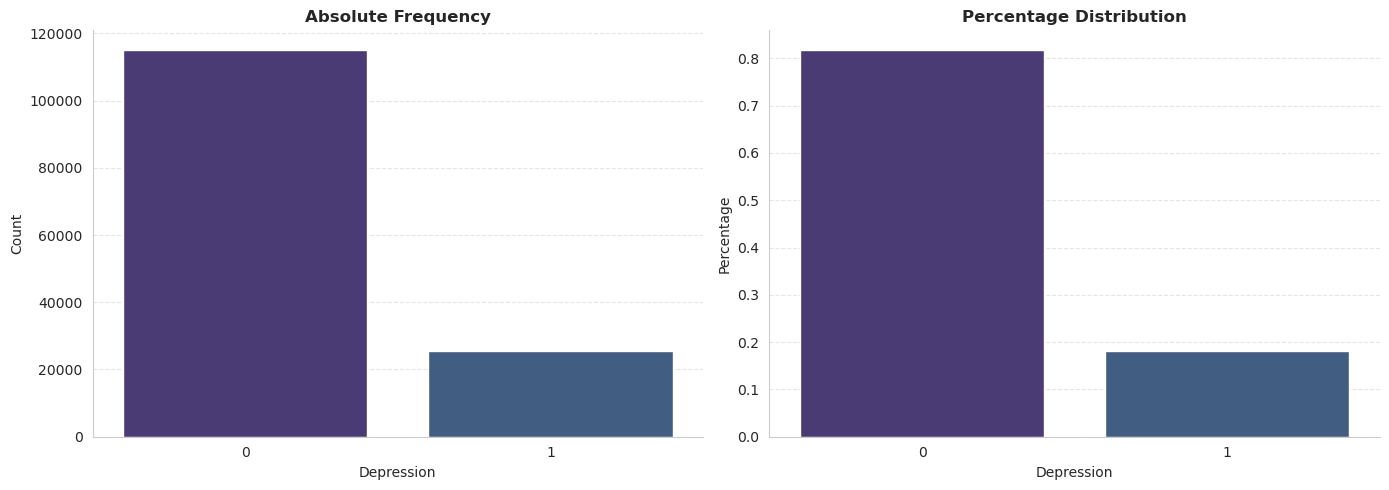

In [157]:
data_overview(train_original, 'Depression')

# Quick PreProcessing about some features

In [158]:
original_data_fix = original_data.copy()
original_data_fix['Depression'] = original_data_fix['Depression'].map({'Yes': 1, 'No': 0})
original_data_fix.head()

Name  Gender  Age       City Working Professional or Student  \
0    Pooja  Female   37  Ghaziabad            Working Professional   
1  Reyansh    Male   60     Kalyan            Working Professional   
2    Manvi  Female   42     Bhopal            Working Professional   
3     Isha  Female   44      Thane            Working Professional   
4    Aarav    Male   48     Indore            Working Professional   

          Profession  Academic Pressure  Work Pressure  CGPA  \
0            Teacher                NaN            2.0   NaN   
1  Financial Analyst                NaN            4.0   NaN   
2            Teacher                NaN            2.0   NaN   
3            Teacher                NaN            3.0   NaN   
4     UX/UI Designer                NaN            4.0   NaN   

   Study Satisfaction  Job Satisfaction Sleep Duration Dietary Habits Degree  \
0                 NaN               4.0      7-8 hours       Moderate     MA   
1                 NaN               3.0      5-6 hours      Unhealthy  B.Com   
2                 NaN               3.0      5-6 hours       Moderate  M.Com   
3                 NaN               5.0      7-8 hours        Healthy     MD   
4                 NaN               3.0      7-8 hours       Moderate     BE   

  Have you ever had suicidal thoughts ?  Work/Study Hours  Financial Stress  \
0                                    No                 6                 2   
1                                   Yes                 0                 4   
2                                    No                 0                 2   
3                                   Yes                 1                 2   
4                                   Yes                 6                 5   

  Family History of Mental Illness  Depression  
0                               No           0  
1                              Yes           0  
2                               No           0  
3                              Yes           0  
4                              Yes           0

# Optional Point: Concat the data

In [159]:
#Concat train and the original data set
train = train_original.copy()
test = test_original.copy()
train.drop('id', axis=1, inplace=True) #id is not needed for training
test.drop('id', axis=1, inplace=True) #id is not needed for testing
train = pd.concat([train, original_data_fix],ignore_index=True)

In [160]:
# just make sure to concat worked,check if the objecte type is the same
train.iloc[train_original.shape[0]-5:train_original.shape[0]+5].head(10)

Name  Gender   Age       City Working Professional or Student  \
140695    Vidya  Female  18.0  Ahmedabad            Working Professional   
140696     Lata  Female  41.0  Hyderabad            Working Professional   
140697  Aanchal  Female  24.0    Kolkata            Working Professional   
140698   Prachi  Female  49.0   Srinagar            Working Professional   
140699      Sai    Male  27.0      Patna                         Student   
140700    Pooja  Female  37.0  Ghaziabad            Working Professional   
140701  Reyansh    Male  60.0     Kalyan            Working Professional   
140702    Manvi  Female  42.0     Bhopal            Working Professional   
140703     Isha  Female  44.0      Thane            Working Professional   
140704    Aarav    Male  48.0     Indore            Working Professional   

               Profession  Academic Pressure  Work Pressure  CGPA  \
140695                NaN                NaN            5.0   NaN   
140696     Content Writer                NaN            5.0   NaN   
140697  Marketing Manager                NaN            3.0   NaN   
140698            Plumber                NaN            5.0   NaN   
140699                NaN                4.0            NaN  9.24   
140700            Teacher                NaN            2.0   NaN   
140701  Financial Analyst                NaN            4.0   NaN   
140702            Teacher                NaN            2.0   NaN   
140703            Teacher                NaN            3.0   NaN   
140704     UX/UI Designer                NaN            4.0   NaN   

        Study Satisfaction  Job Satisfaction     Sleep Duration  \
140695                 NaN               4.0          5-6 hours   
140696                 NaN               4.0          7-8 hours   
140697                 NaN               1.0  More than 8 hours   
140698                 NaN               2.0          5-6 hours   
140699                 1.0               NaN  Less than 5 hours   
140700                 NaN               4.0          7-8 hours   
140701                 NaN               3.0          5-6 hours   
140702                 NaN               3.0          5-6 hours   
140703                 NaN               5.0          7-8 hours   
140704                 NaN               3.0          7-8 hours   

       Dietary Habits    Degree Have you ever had suicidal thoughts ?  \
140695      Unhealthy  Class 12                                    No   
140696       Moderate    B.Tech                                   Yes   
140697       Moderate     B.Com                                    No   
140698       Moderate        ME                                   Yes   
140699        Healthy       BCA                                   Yes   
140700       Moderate        MA                                    No   
140701      Unhealthy     B.Com                                   Yes   
140702       Moderate     M.Com                                    No   
140703        Healthy        MD                                   Yes   
140704       Moderate        BE                                   Yes   

        Work/Study Hours  Financial Stress Family History of Mental Illness  \
140695               2.0               4.0                              Yes   
140696               6.0               5.0                              Yes   
140697               4.0               4.0                               No   
140698              10.0               1.0                               No   
140699               2.0               3.0                              Yes   
140700               6.0               2.0                               No   
140701               0.0               4.0                              Yes   
140702               0.0               2.0                               No   
140703               1.0               2.0                              Yes   
140704               6.0               5.0                              Yes   

  

# Feature Analyse

## Numeric Feature Attributes

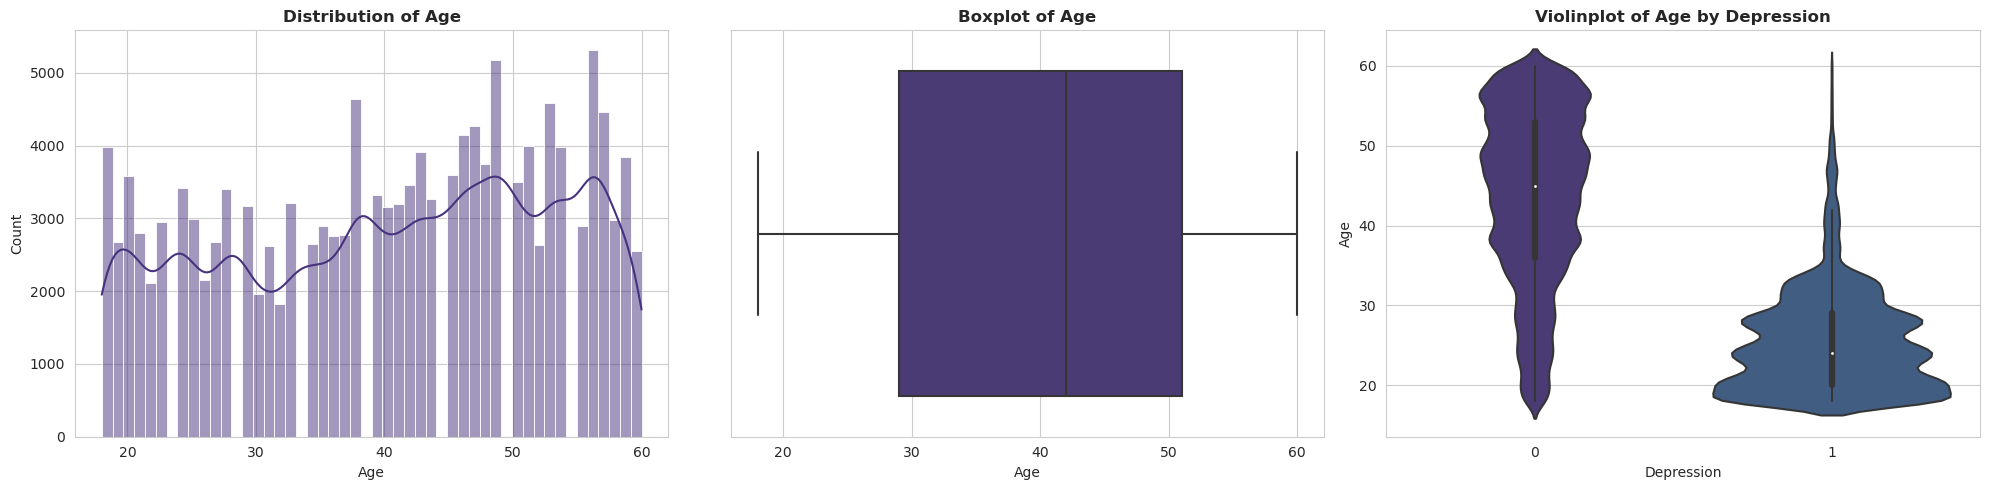

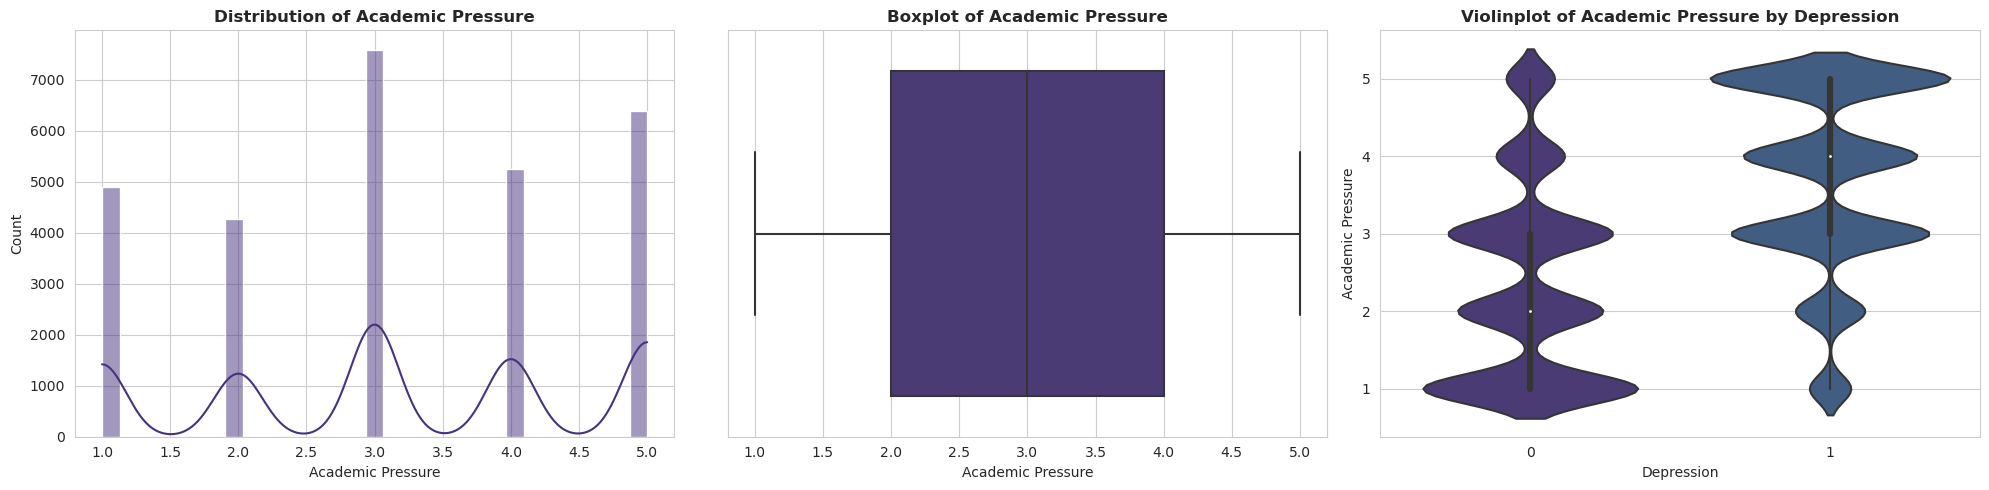

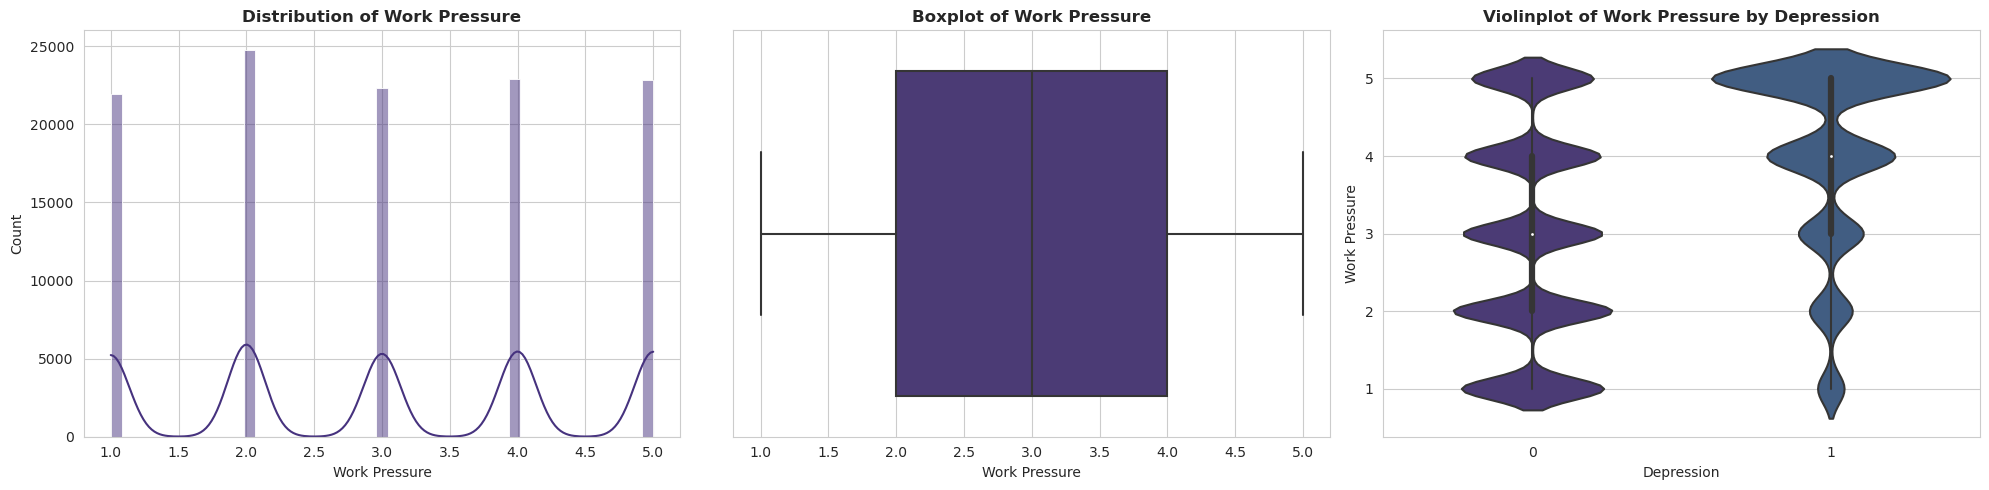

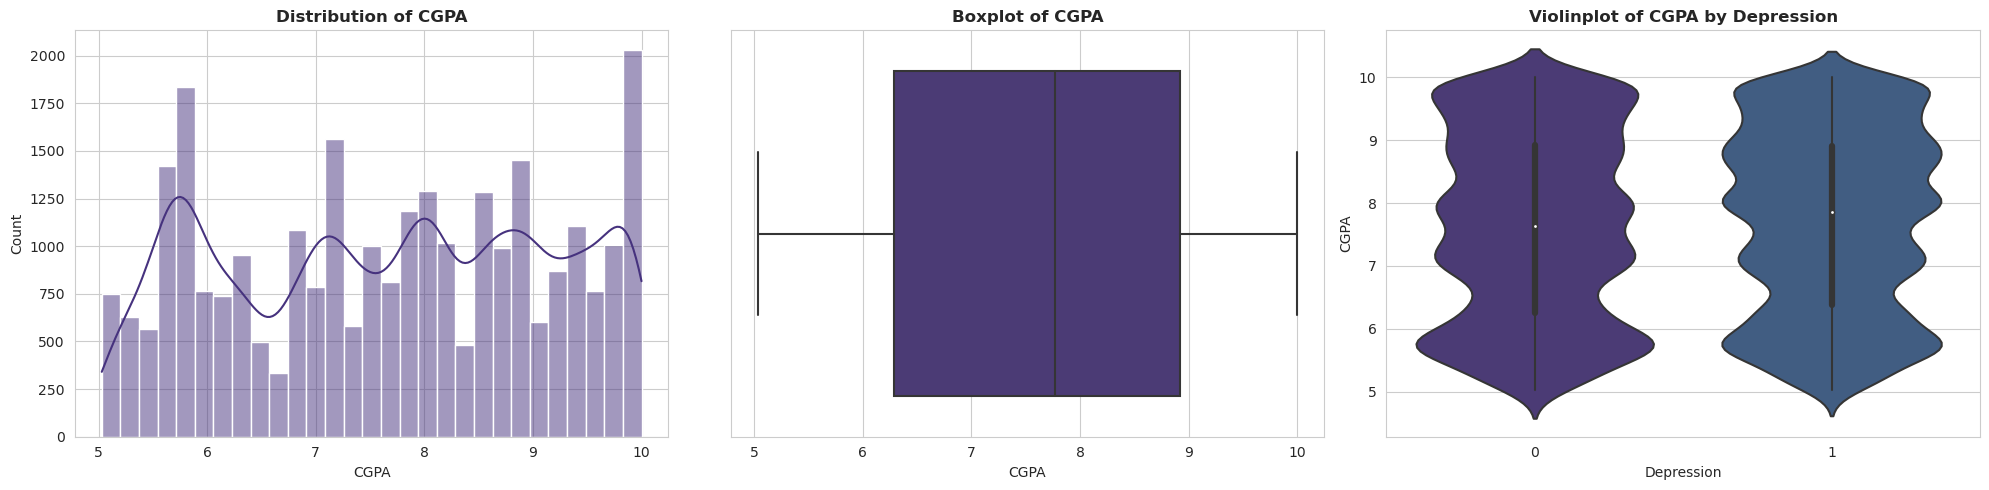

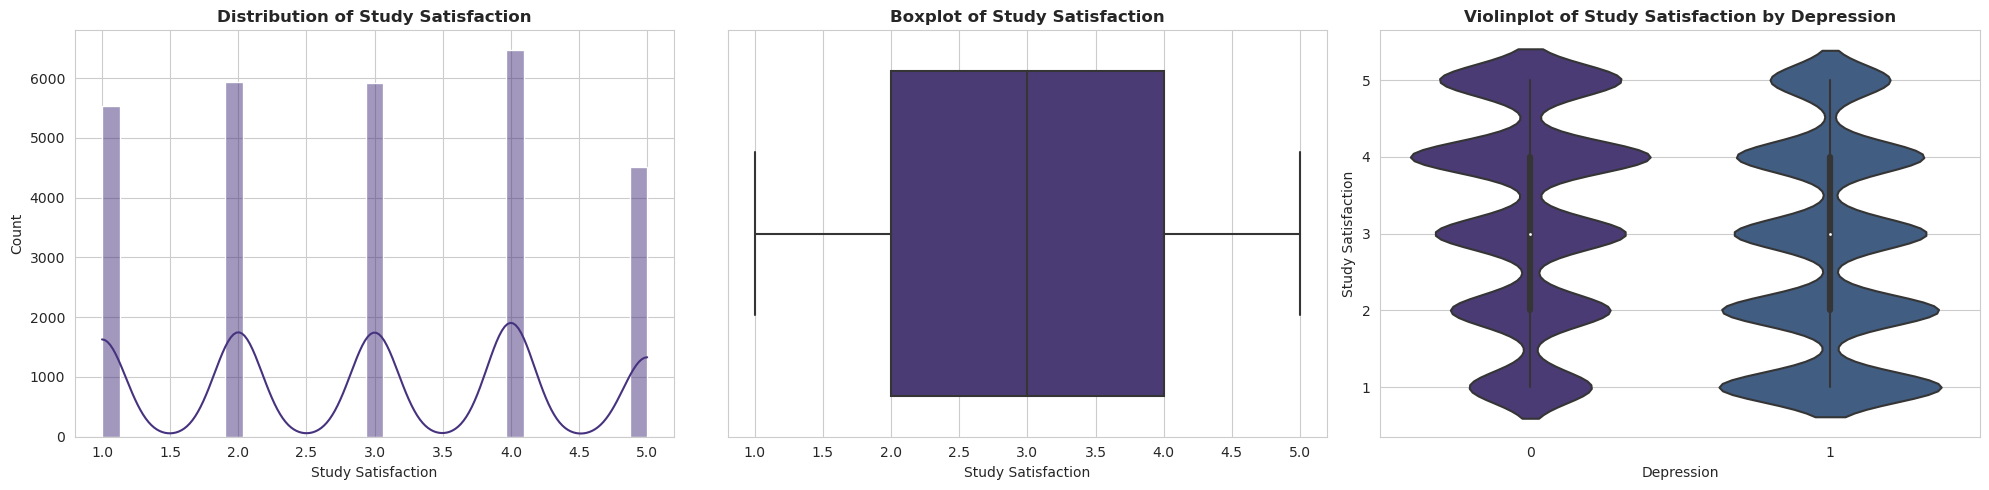

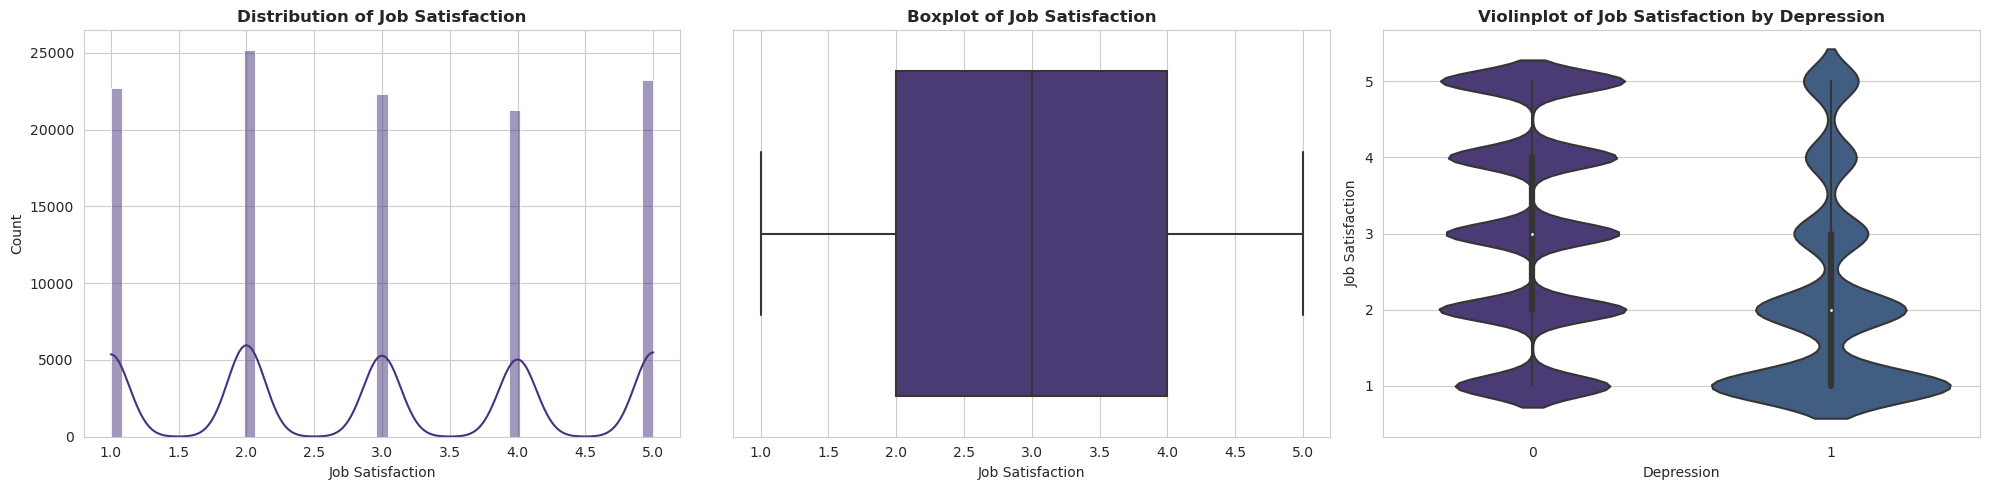

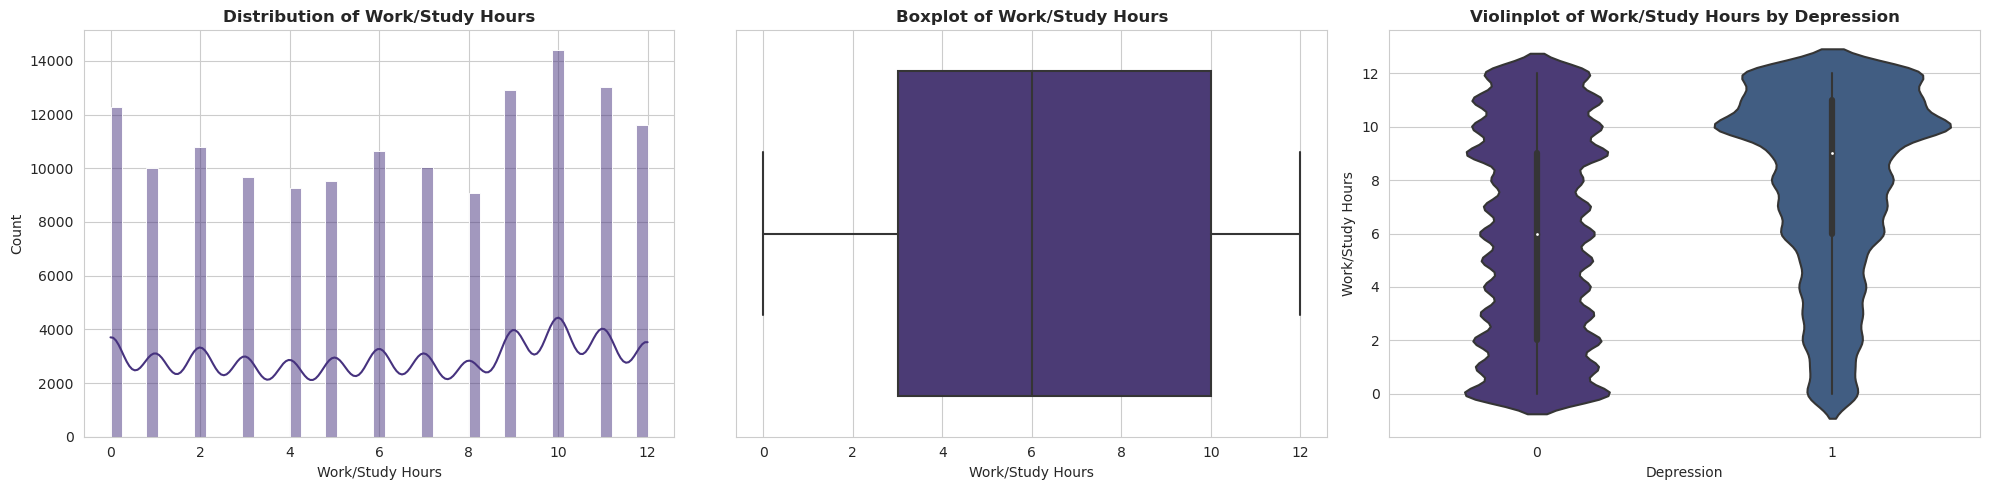

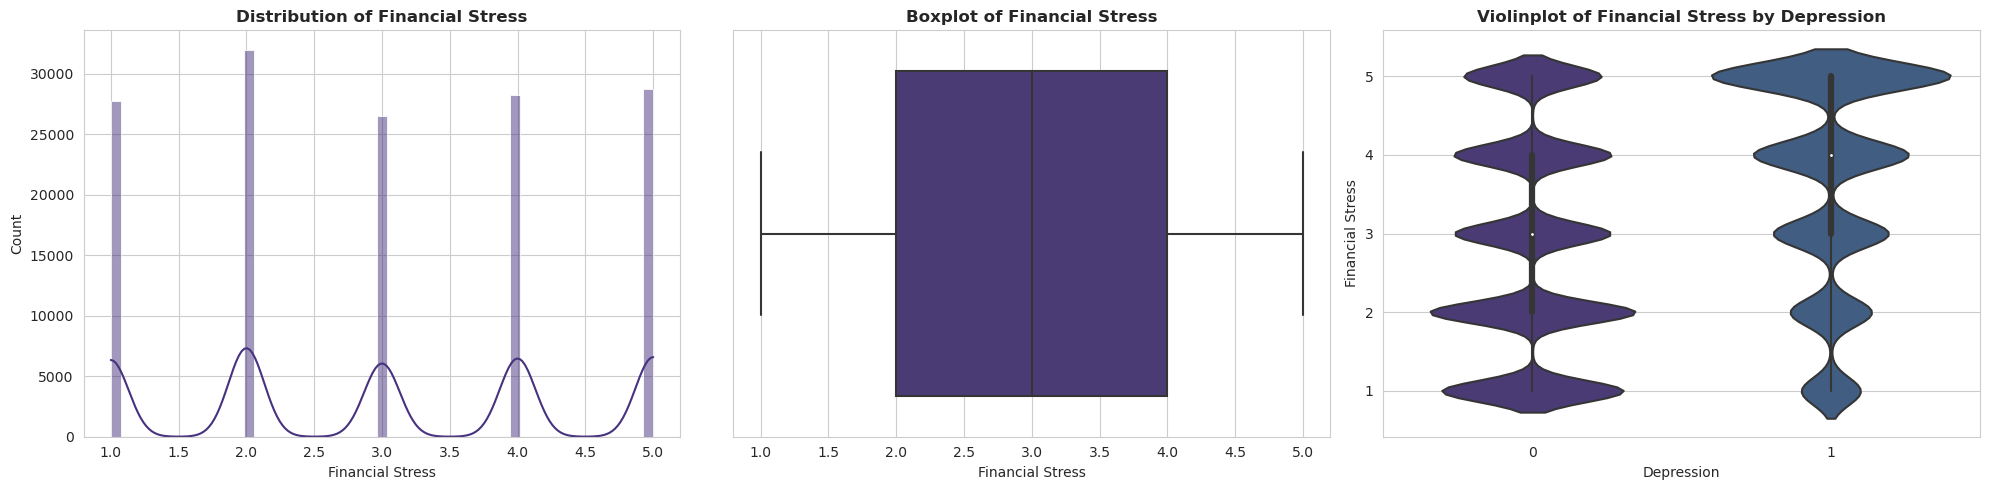

## Categorical Feature Attributes

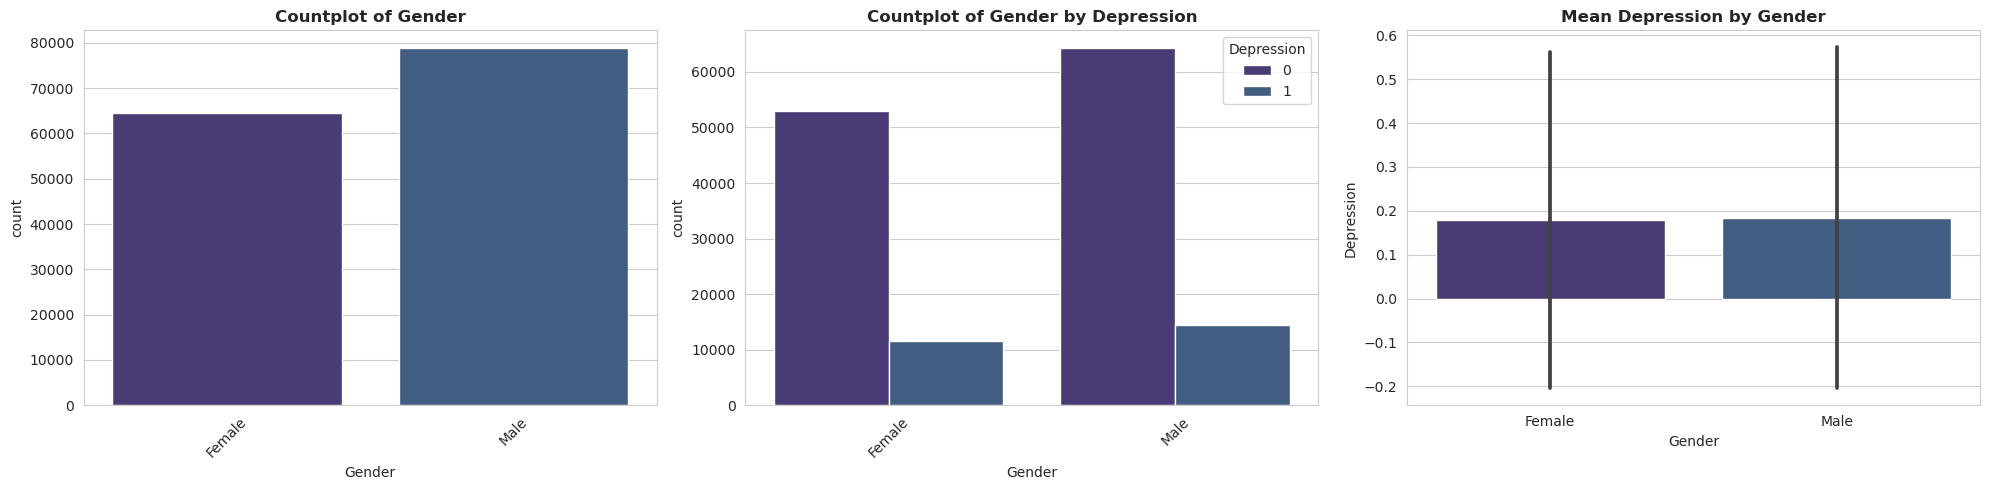

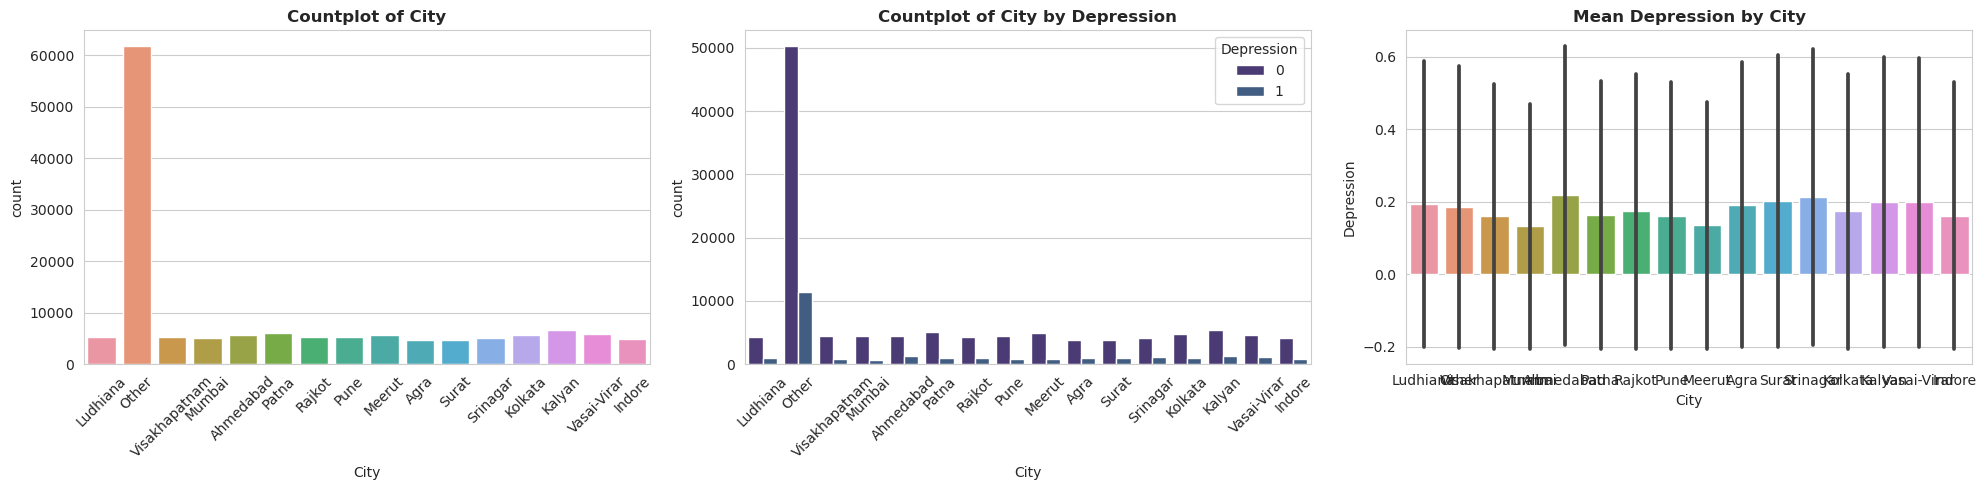

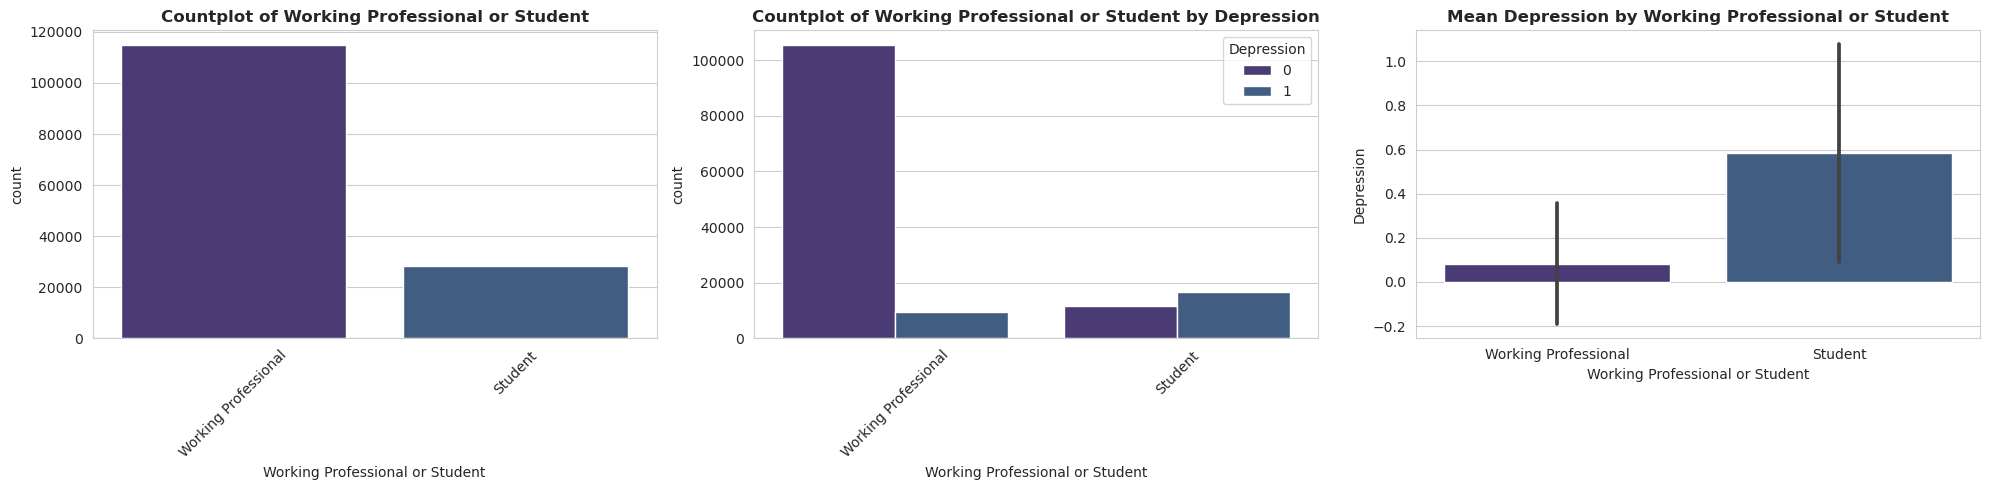

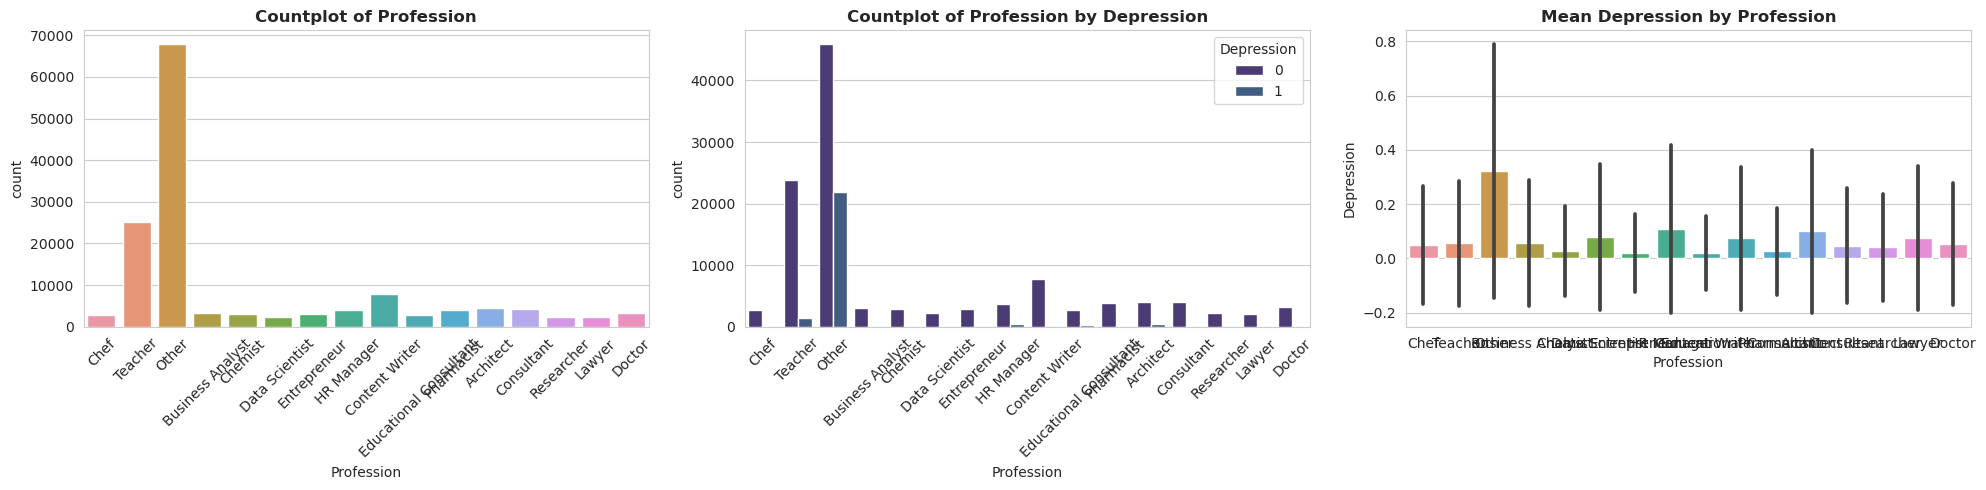

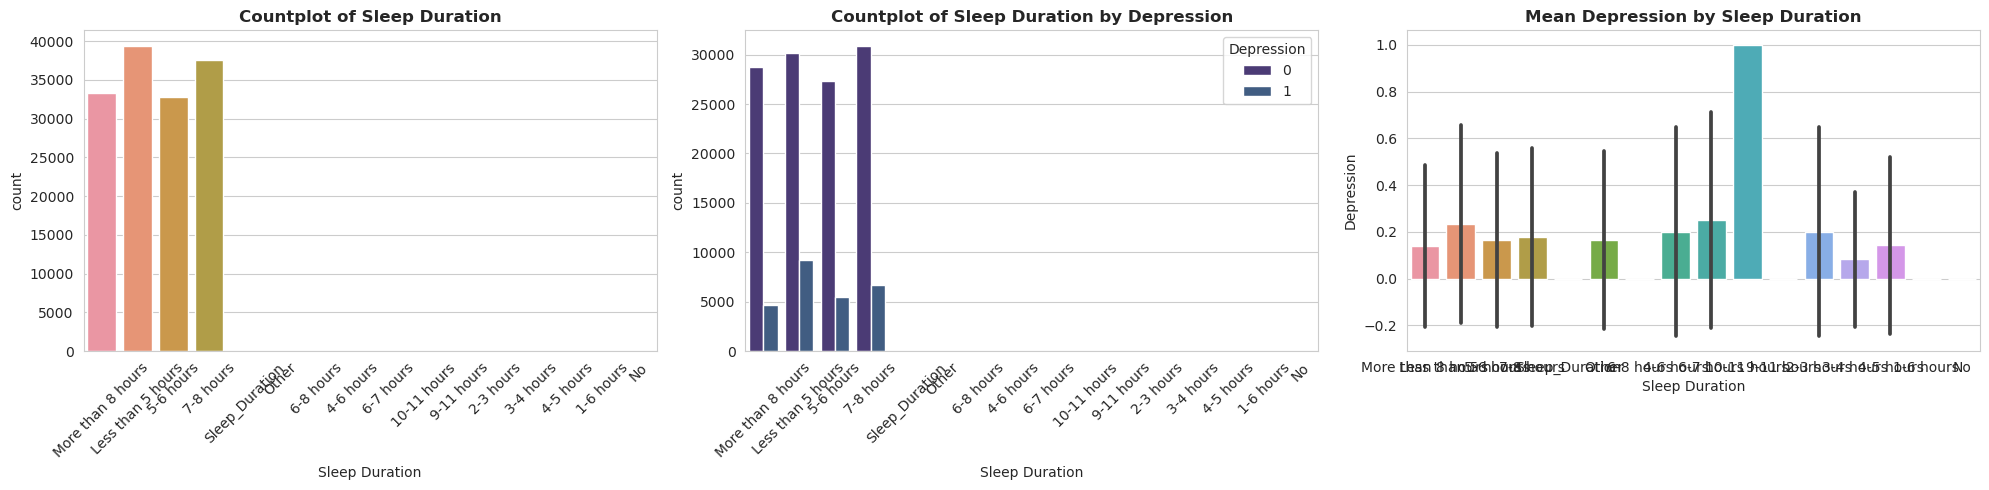

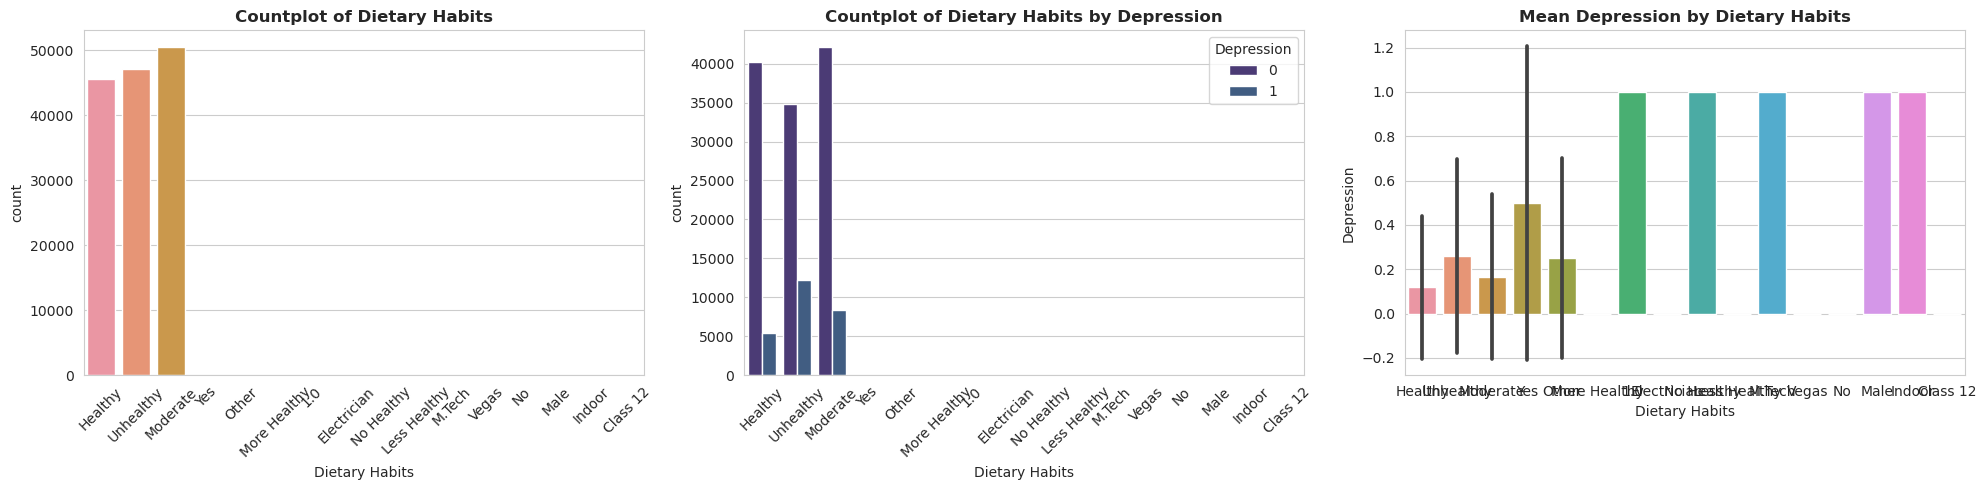

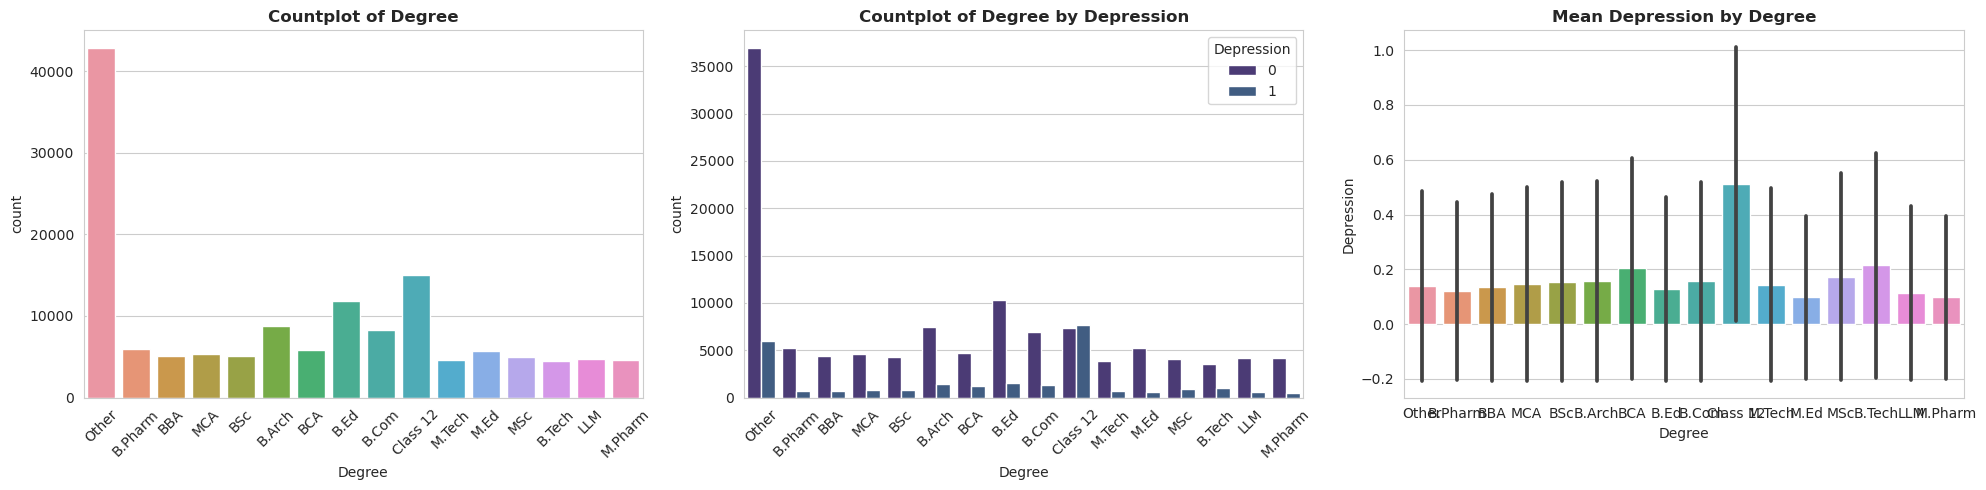

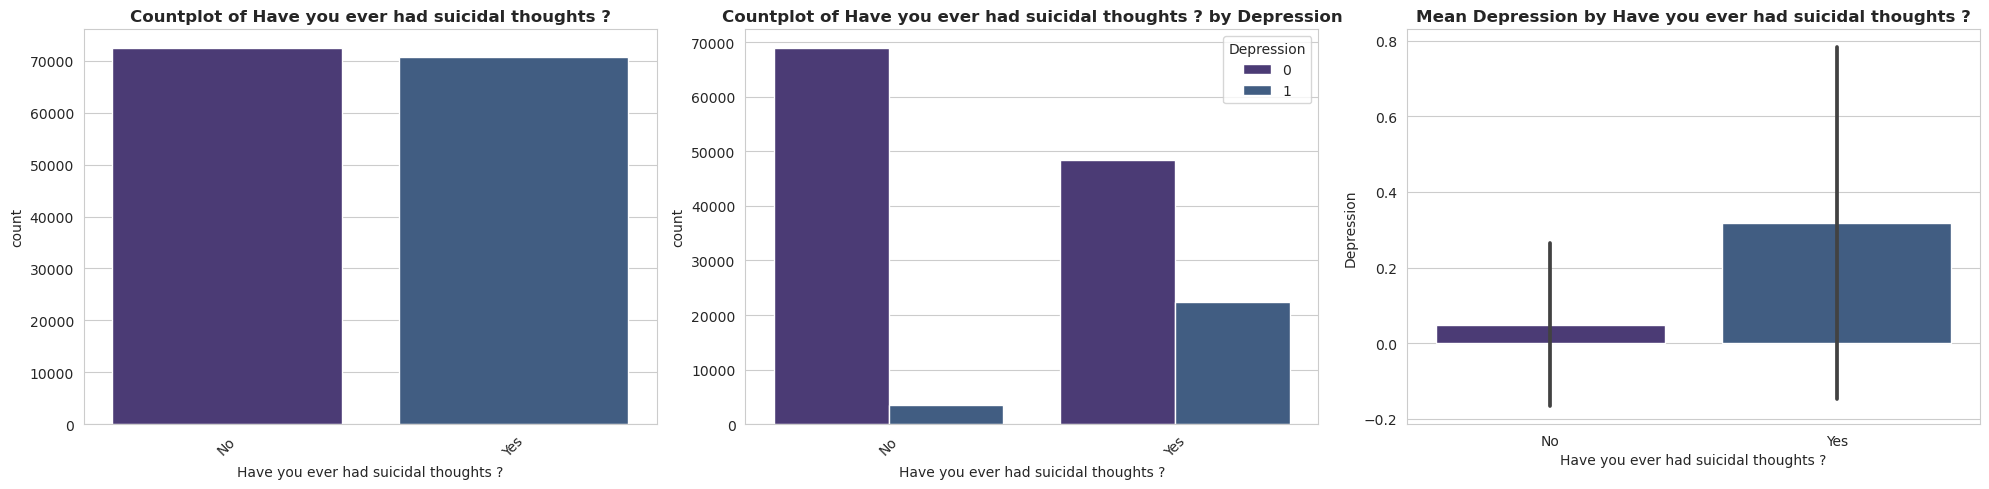

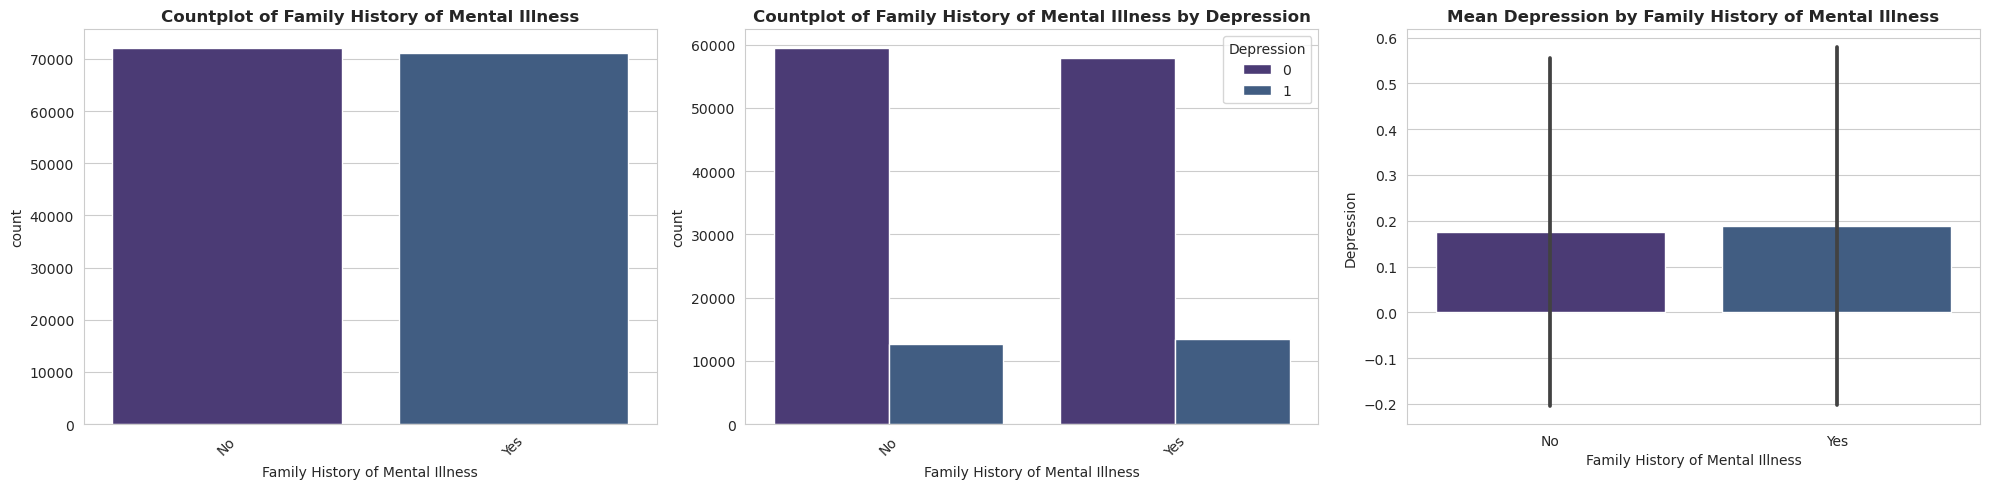

In [161]:
def visualize_feature_attributes(df, target=None):
    """ Visualizes numeric and categorical features """

    # Get Numeric & Categorical Features
    numeric_features, categorical_features =get_categorical_numerical_features(df)

    # Numeric Features
    if numeric_features:
        display(Markdown("## Numeric Feature Attributes"))
        for col in numeric_features:
            if col != target:
                plot_numeric_feature(df, col, target)
    else:
        print("No numeric features found.")

    # Categorical Features
    if categorical_features:
        display(Markdown("## Categorical Feature Attributes"))
        for col in categorical_features:
            if col != target:
                if df[col].nunique() > 10:
                    df = reduce_categories(df, col, top_n=15)
                plot_categorical_feature(df, col, target)
    else:
        print("No categorical features found.")


def plot_numeric_feature(df, col, target):
    """ Plots Histogram, Boxplot, and Violinplot for a numeric feature """
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    sns.histplot(df[col], ax=axes[0], kde=True)
    axes[0].set_title(f"Distribution of {col}", fontweight="bold")

    sns.boxplot(x=df[col], ax=axes[1])
    axes[1].set_title(f"Boxplot of {col}", fontweight="bold")

    if target and target in df.columns and df[target].nunique() == 2:
        sns.violinplot(x=df[target], y=df[col], ax=axes[2], split=True)
    elif target and target in df.columns:
        sns.violinplot(x=df[target], y=df[col], ax=axes[2], split=False)
    else:
        sns.violinplot(y=df[col], ax=axes[2])

    axes[2].set_title(f"Violinplot of {col} by {target}", fontweight="bold")

    plt.tight_layout()
    plt.show()


def plot_categorical_feature(df, col, target):
    """ Plots Countplot, Hue-Countplot, and Barplot (if target is numeric) for a categorical feature """
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    sns.countplot(x=df[col], ax=axes[0])
    axes[0].set_title(f"Countplot of {col}", fontweight="bold")
    axes[0].tick_params(axis='x', rotation=45)

    if target in df.columns:
        sns.countplot(x=df[col], hue=df[target], ax=axes[1])
        axes[1].set_title(f"Countplot of {col} by {target}", fontweight="bold")
        axes[1].tick_params(axis='x', rotation=45)

    if target in df.columns and df[target].dtype in [np.float64, np.int64]:
        sns.barplot(x=df[col], y=df[target], ax=axes[2], estimator=np.mean, errorbar='sd')
        axes[2].set_title(f"Mean {target} by {col}", fontweight="bold")
    else:
        axes[2].remove()  

    plt.tight_layout()
    plt.show()
    

def reduce_categories(df, col, top_n):
    """ Shows only the categories with highes numbers, seldoms are shown with "others" """
    top_categories = df[col].value_counts().nlargest(top_n).index
    df[col] = df[col].apply(lambda x: x if x in top_categories else 'Other')
    return df

def get_categorical_numerical_features(df):
    # Get Numeric & Categorical Features
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
    return numeric_features, categorical_features

visualize_feature_attributes(train.drop(columns=['Name']), target="Depression")

# Correlation Matrix (Numerical values)

<Axes: >

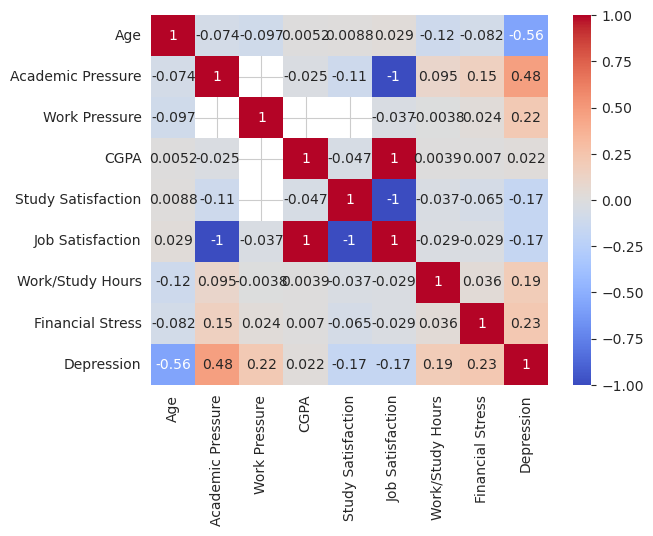

In [162]:
# Get Numeric & Categorical Features
numeric_features, categorical_features = get_categorical_numerical_features(train)
sns.heatmap(train[numeric_features].corr(), annot=True, cmap='coolwarm')

# Analyse categorical features

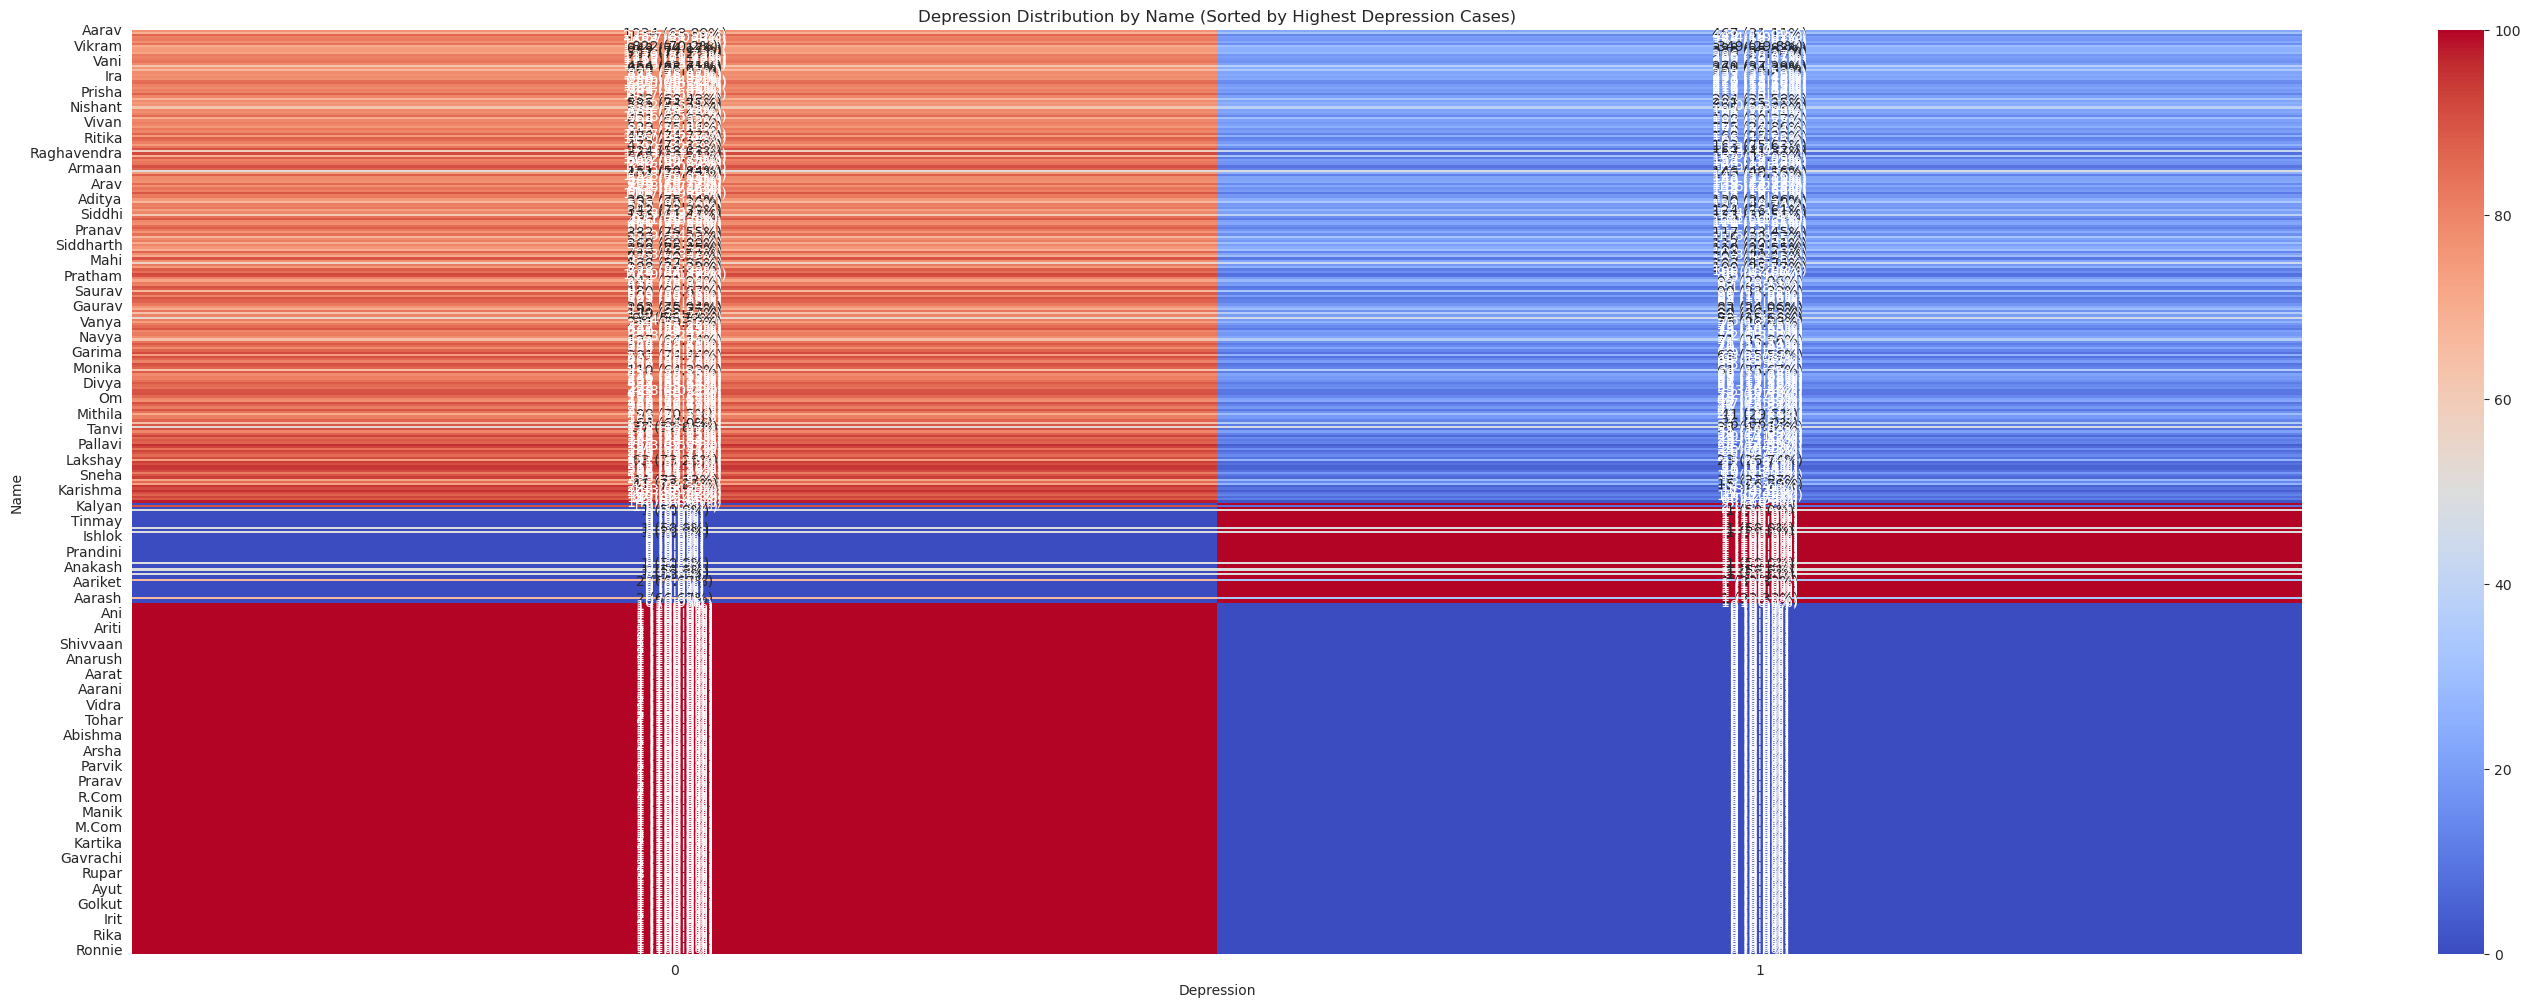

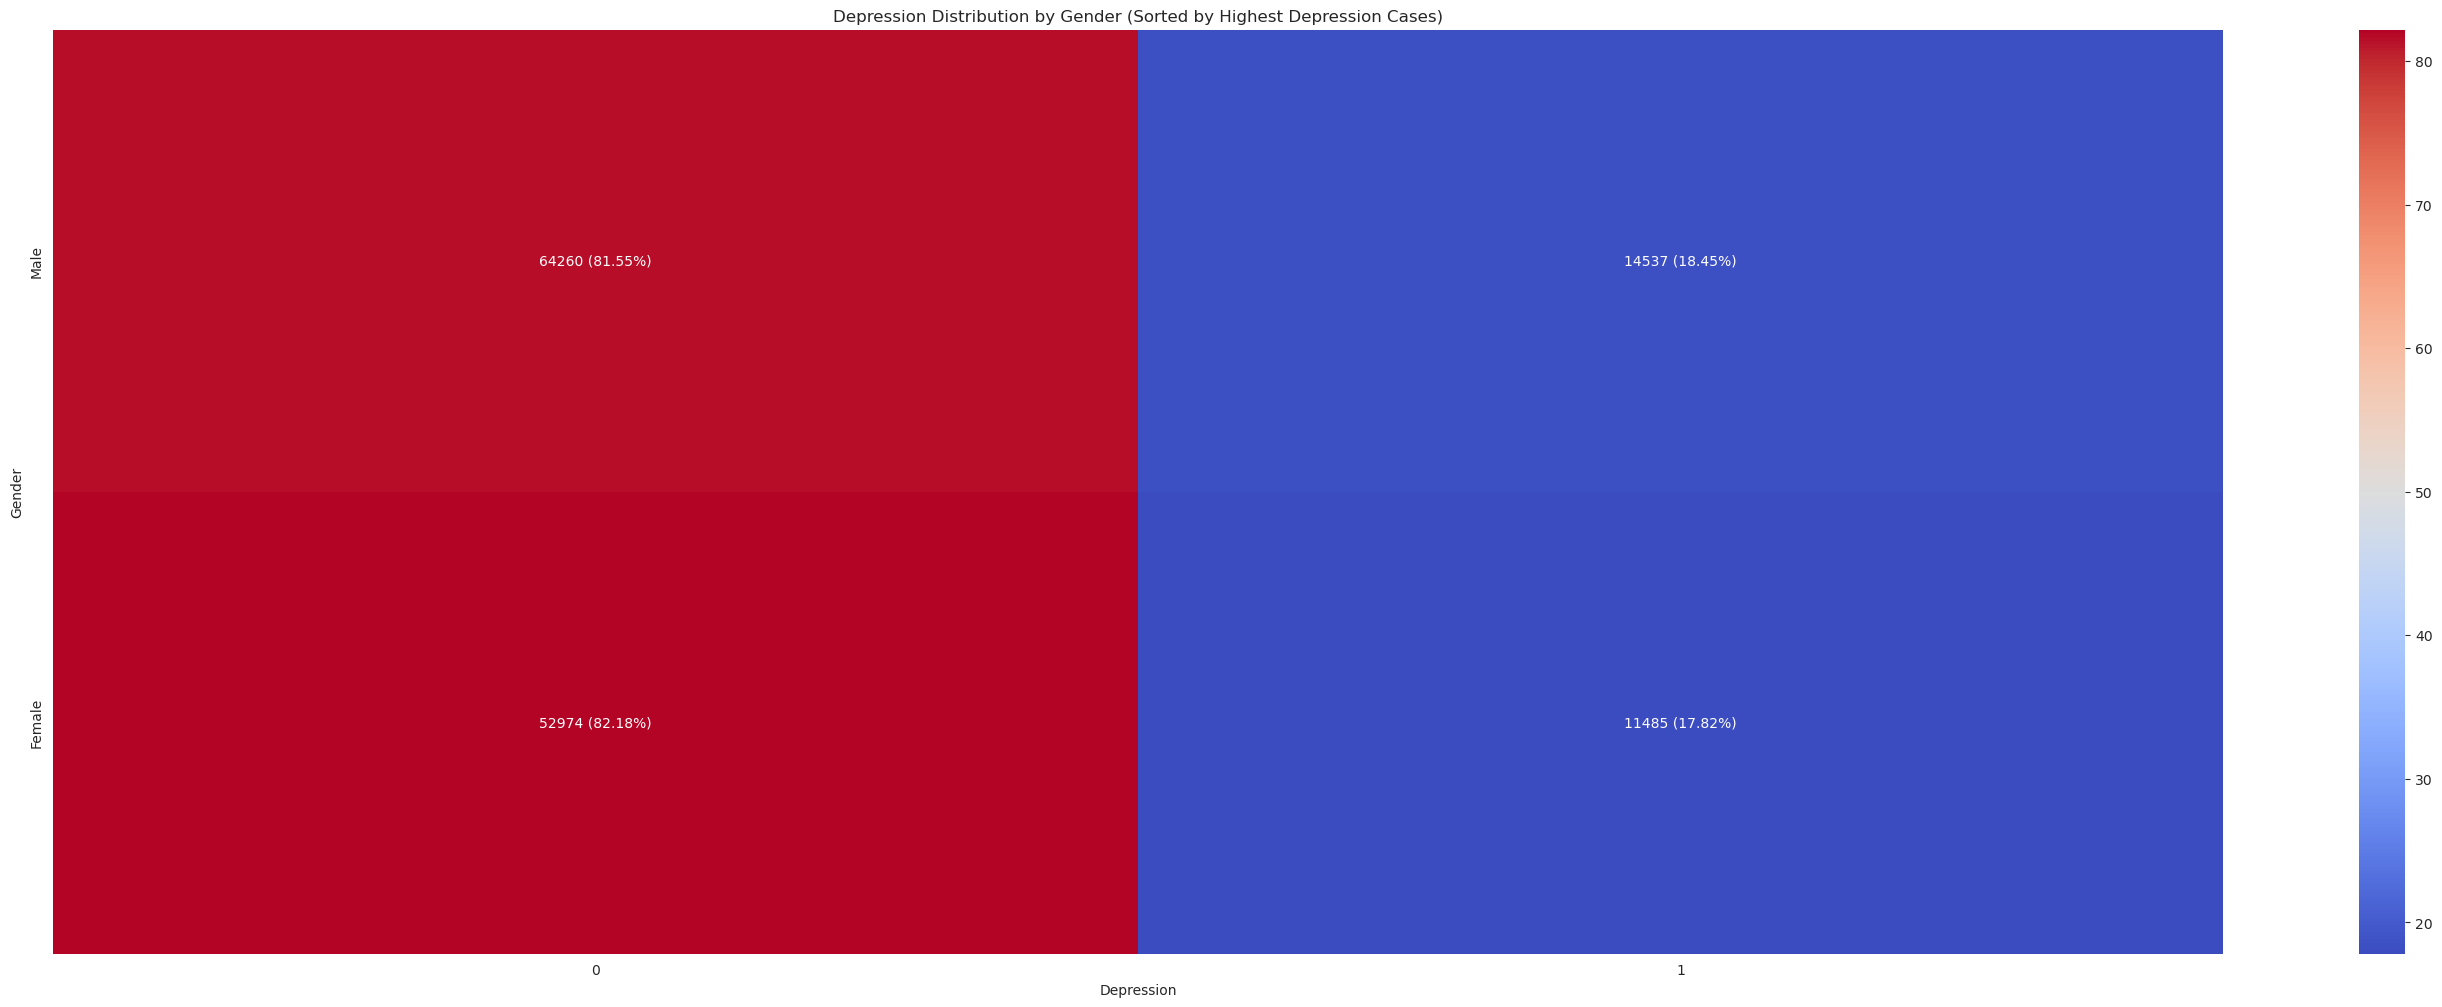

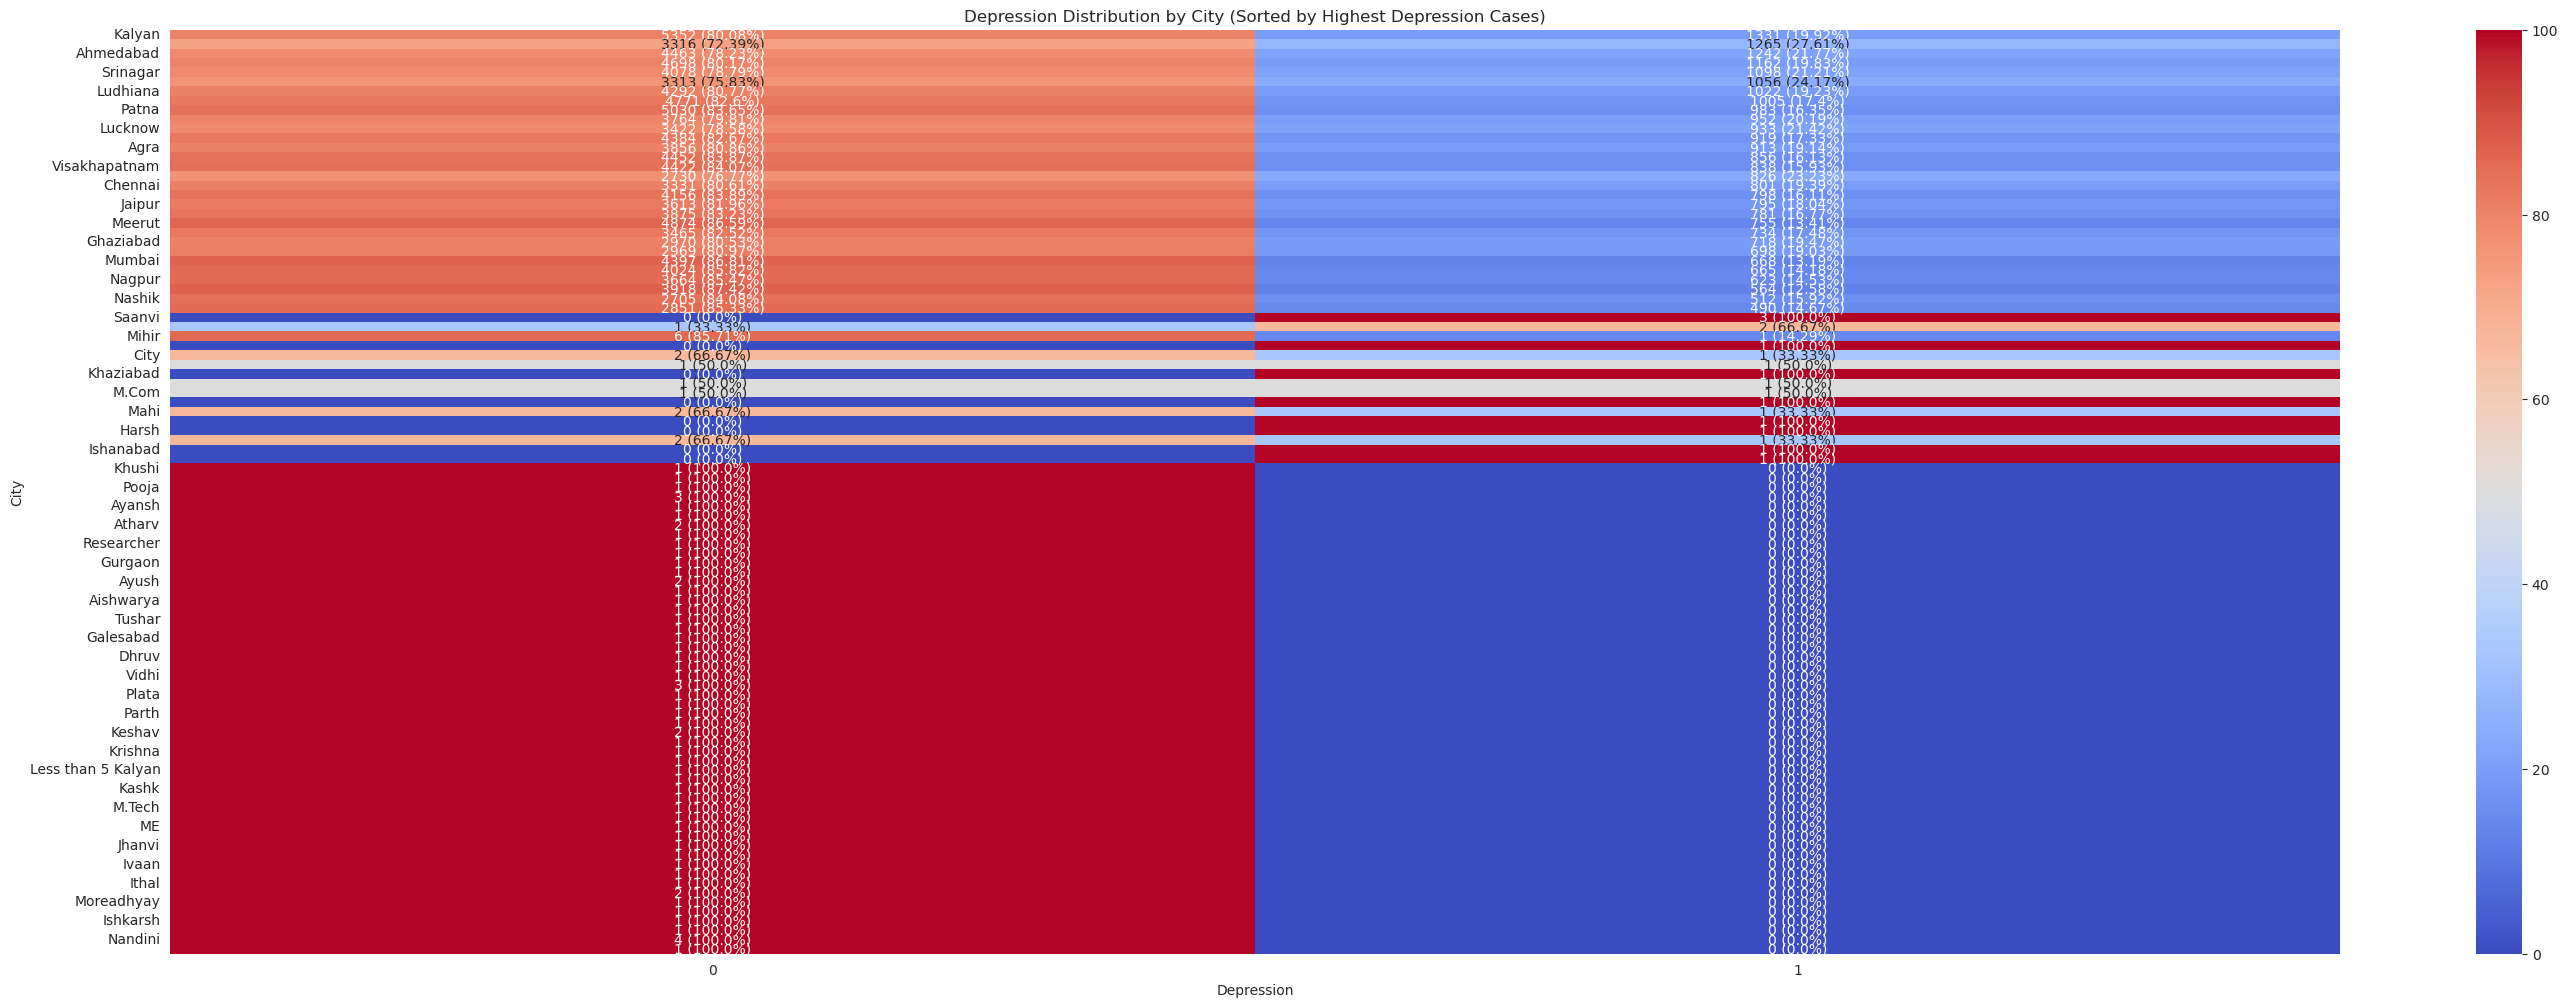

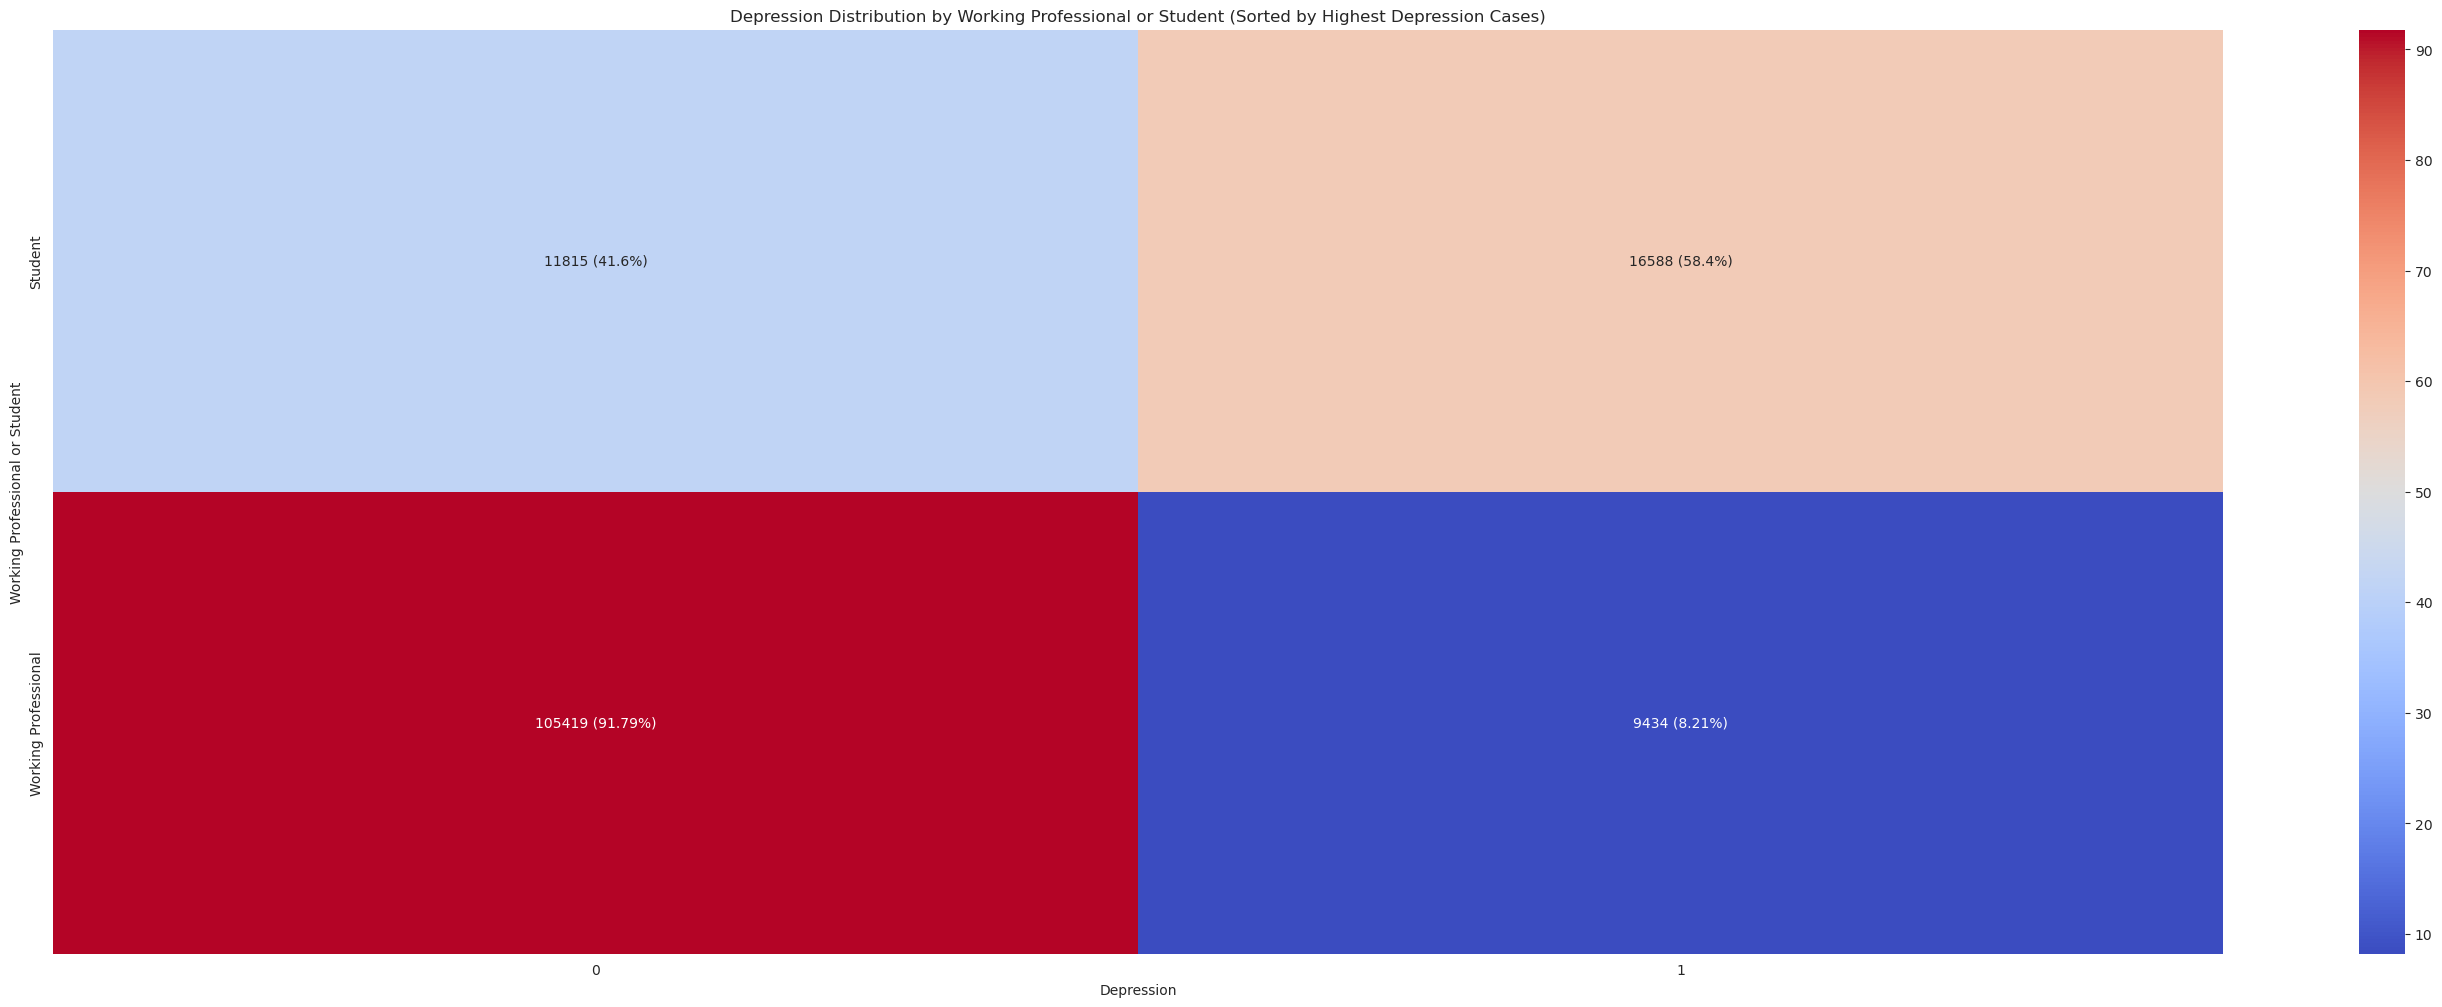

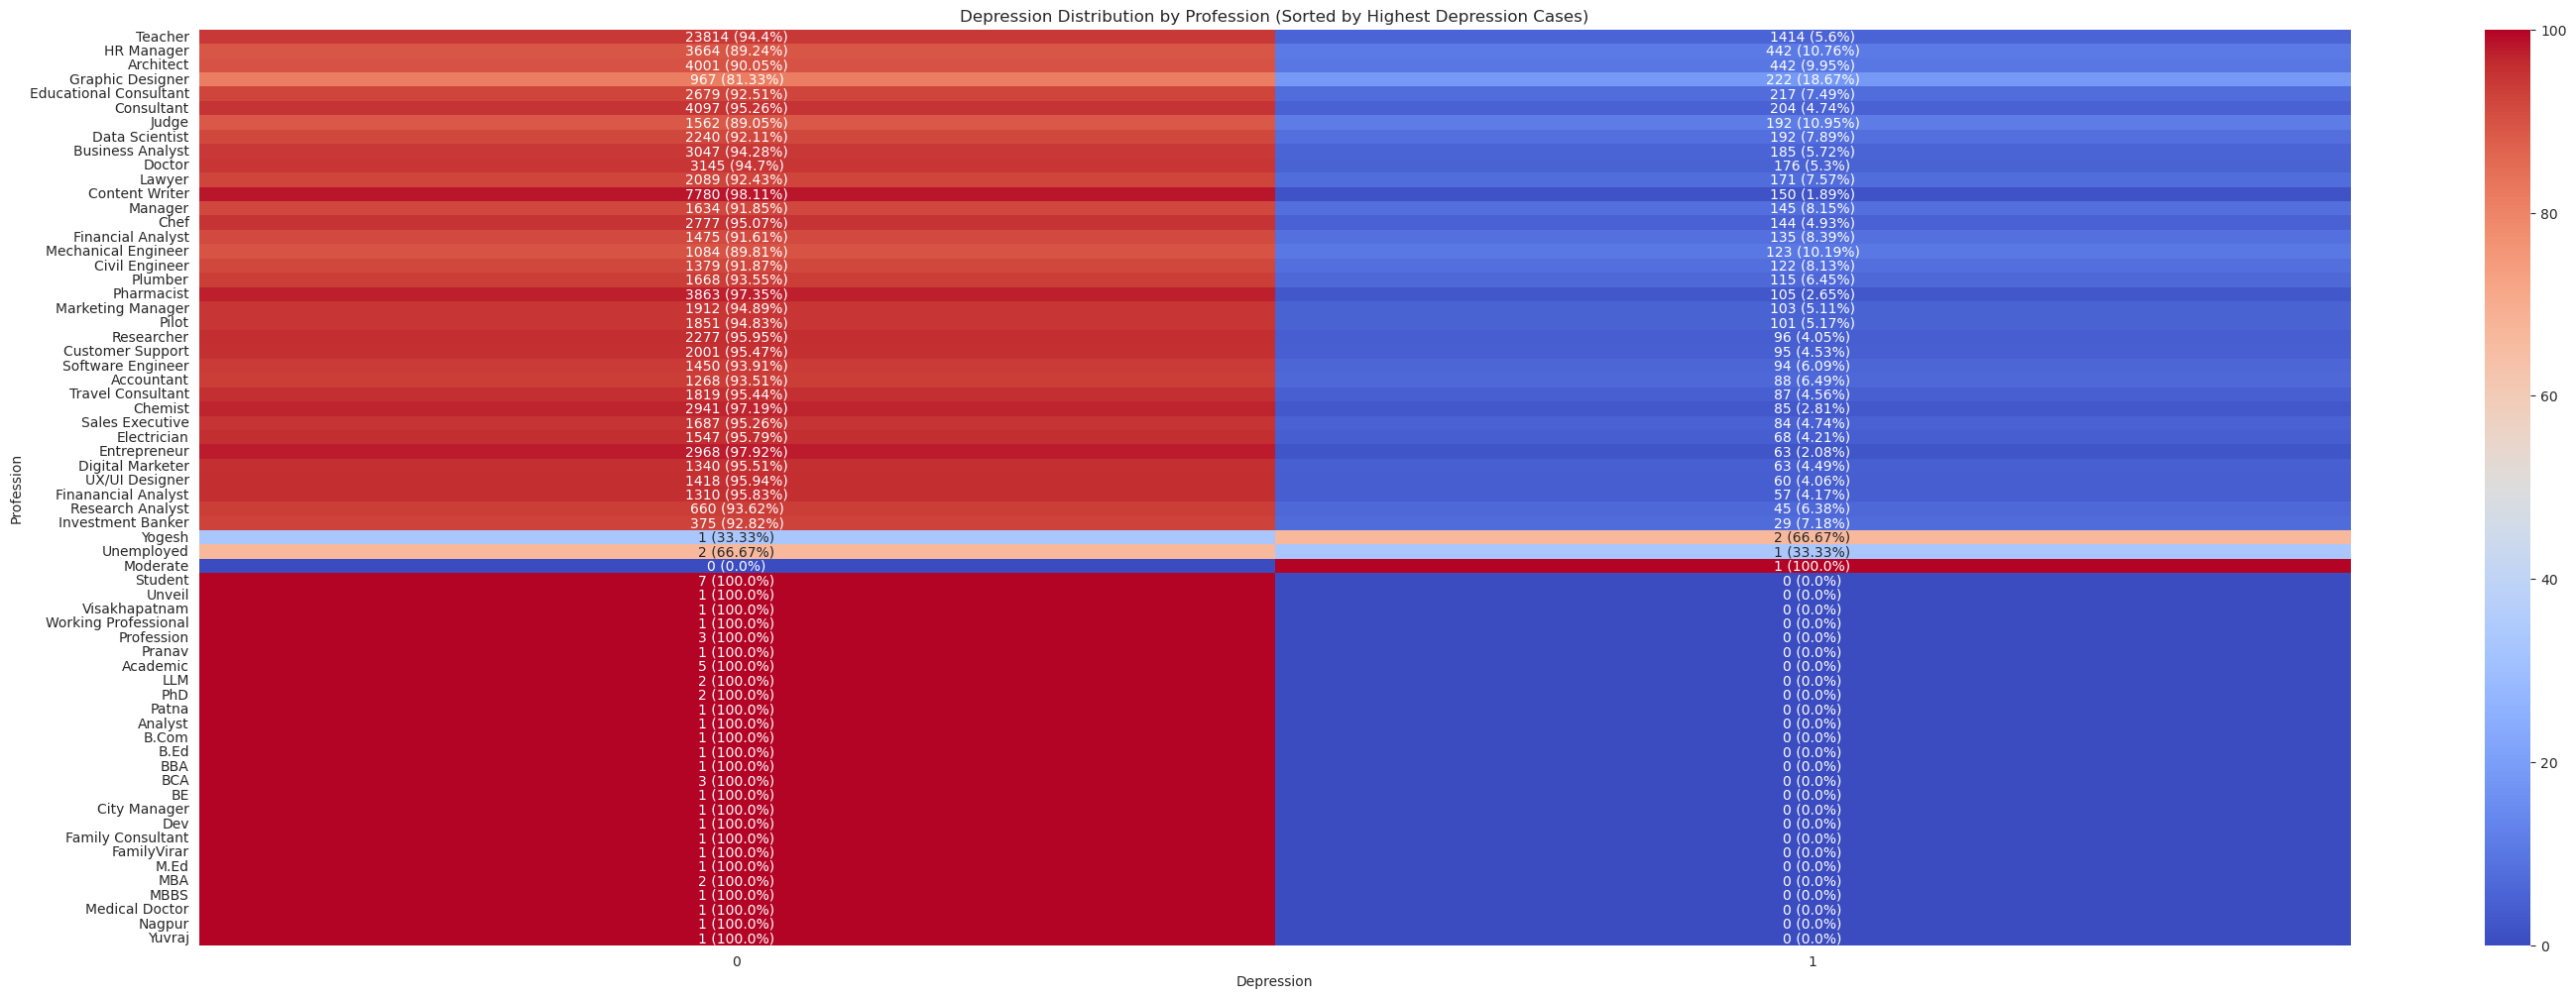

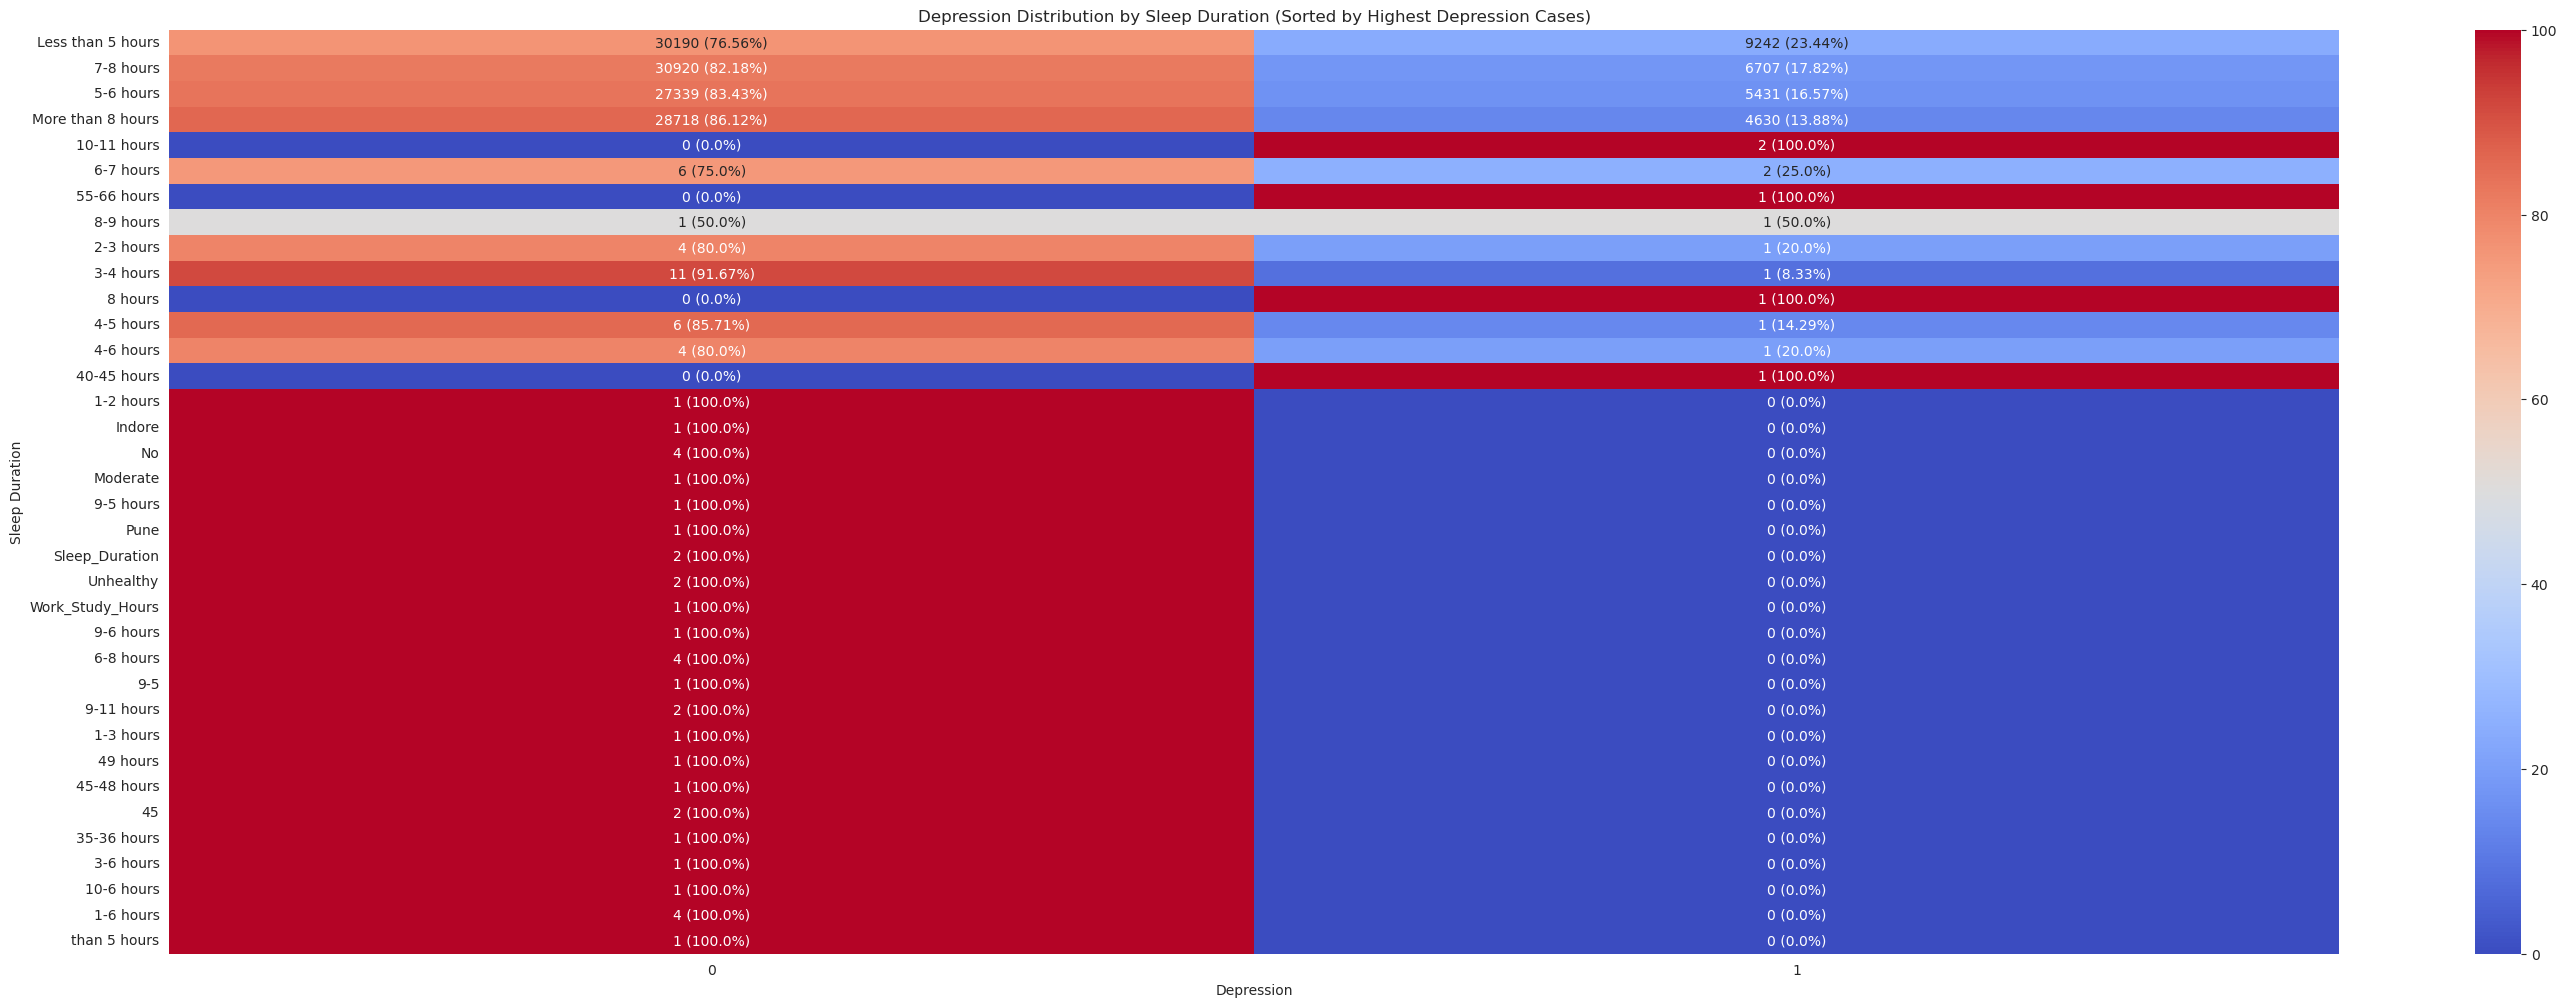

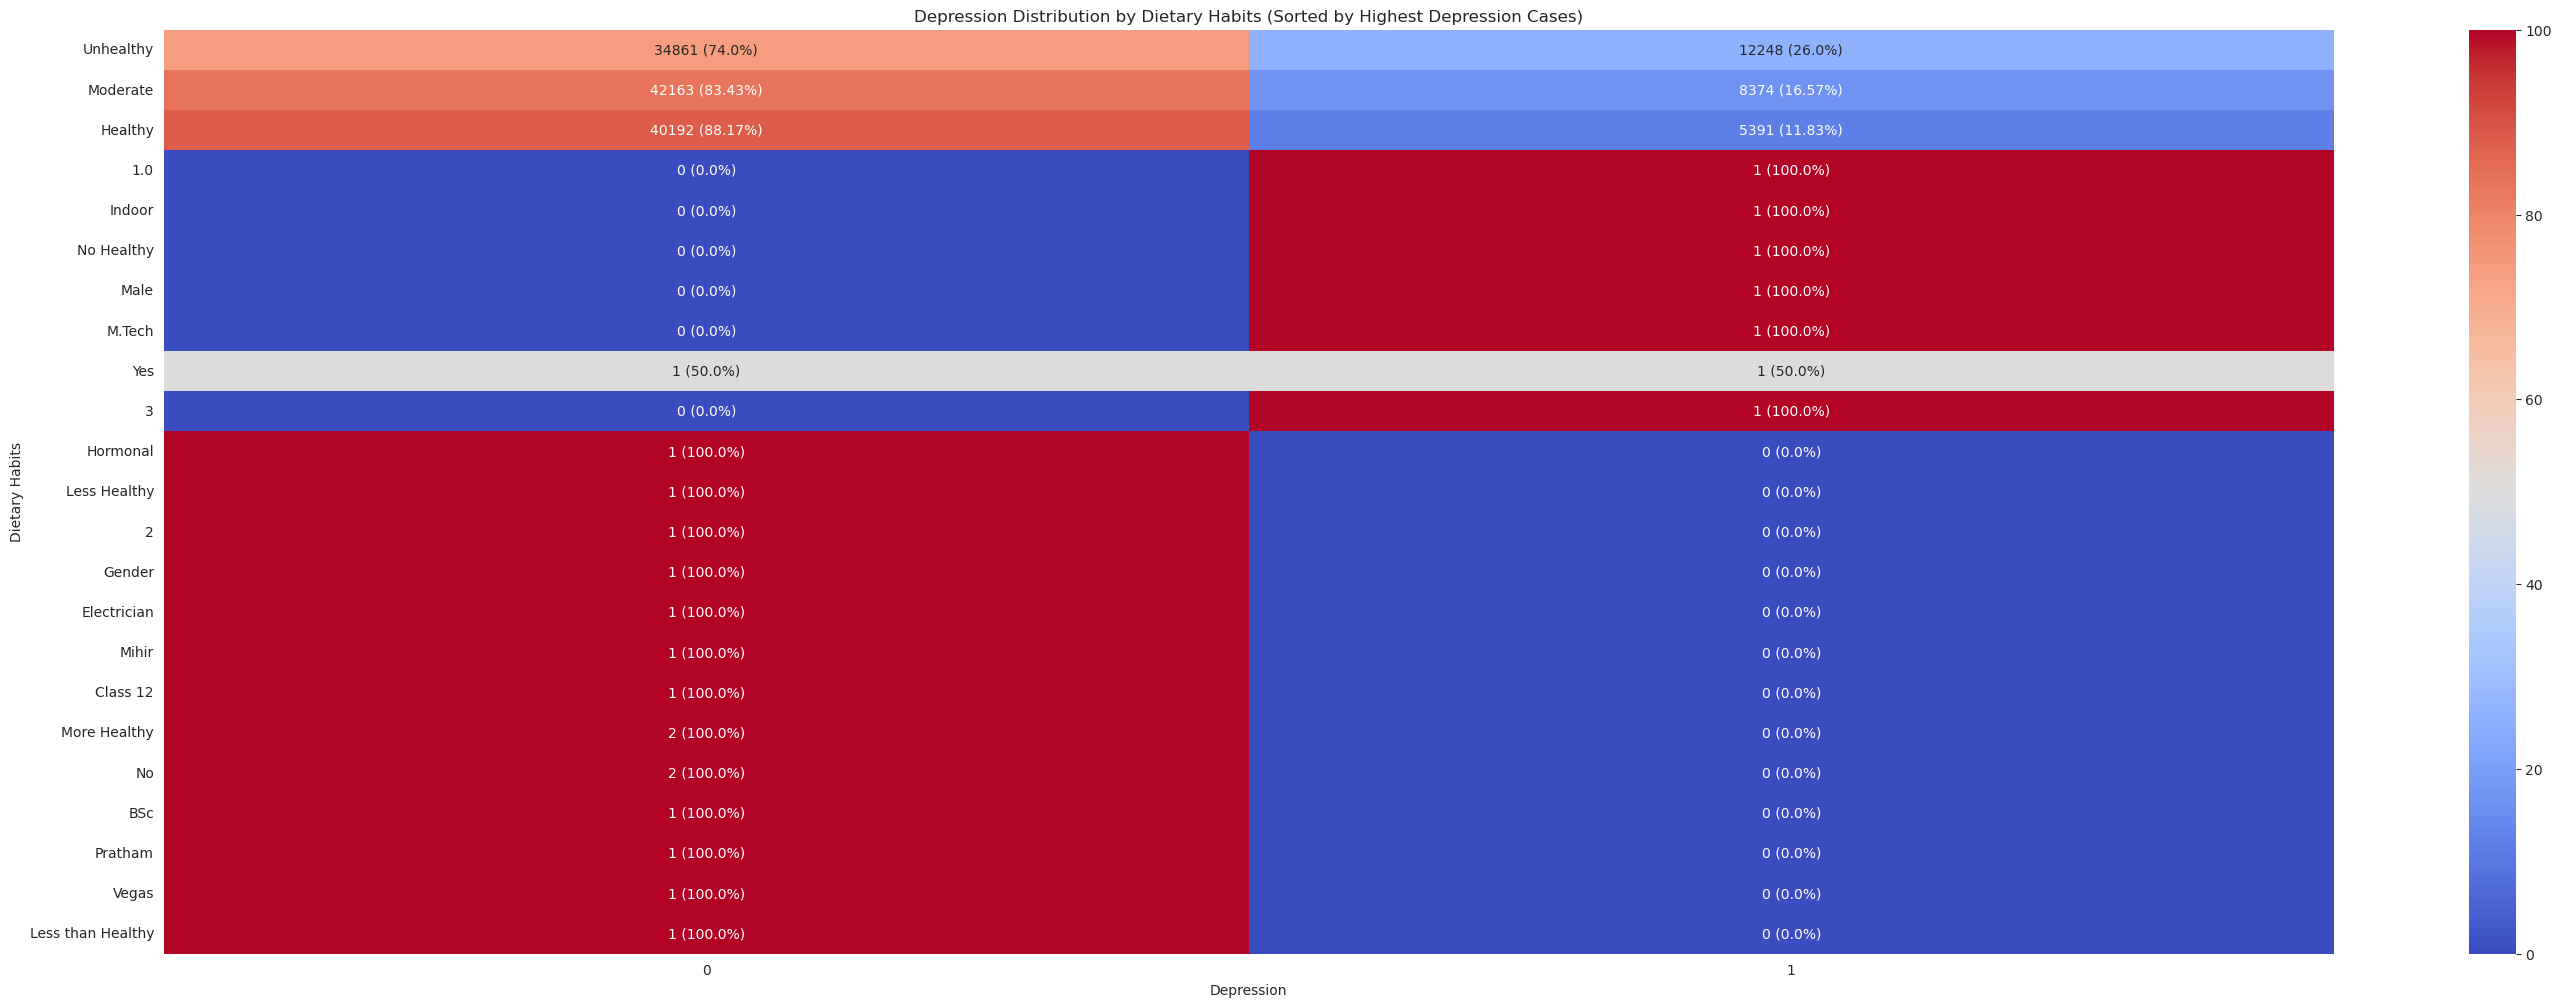

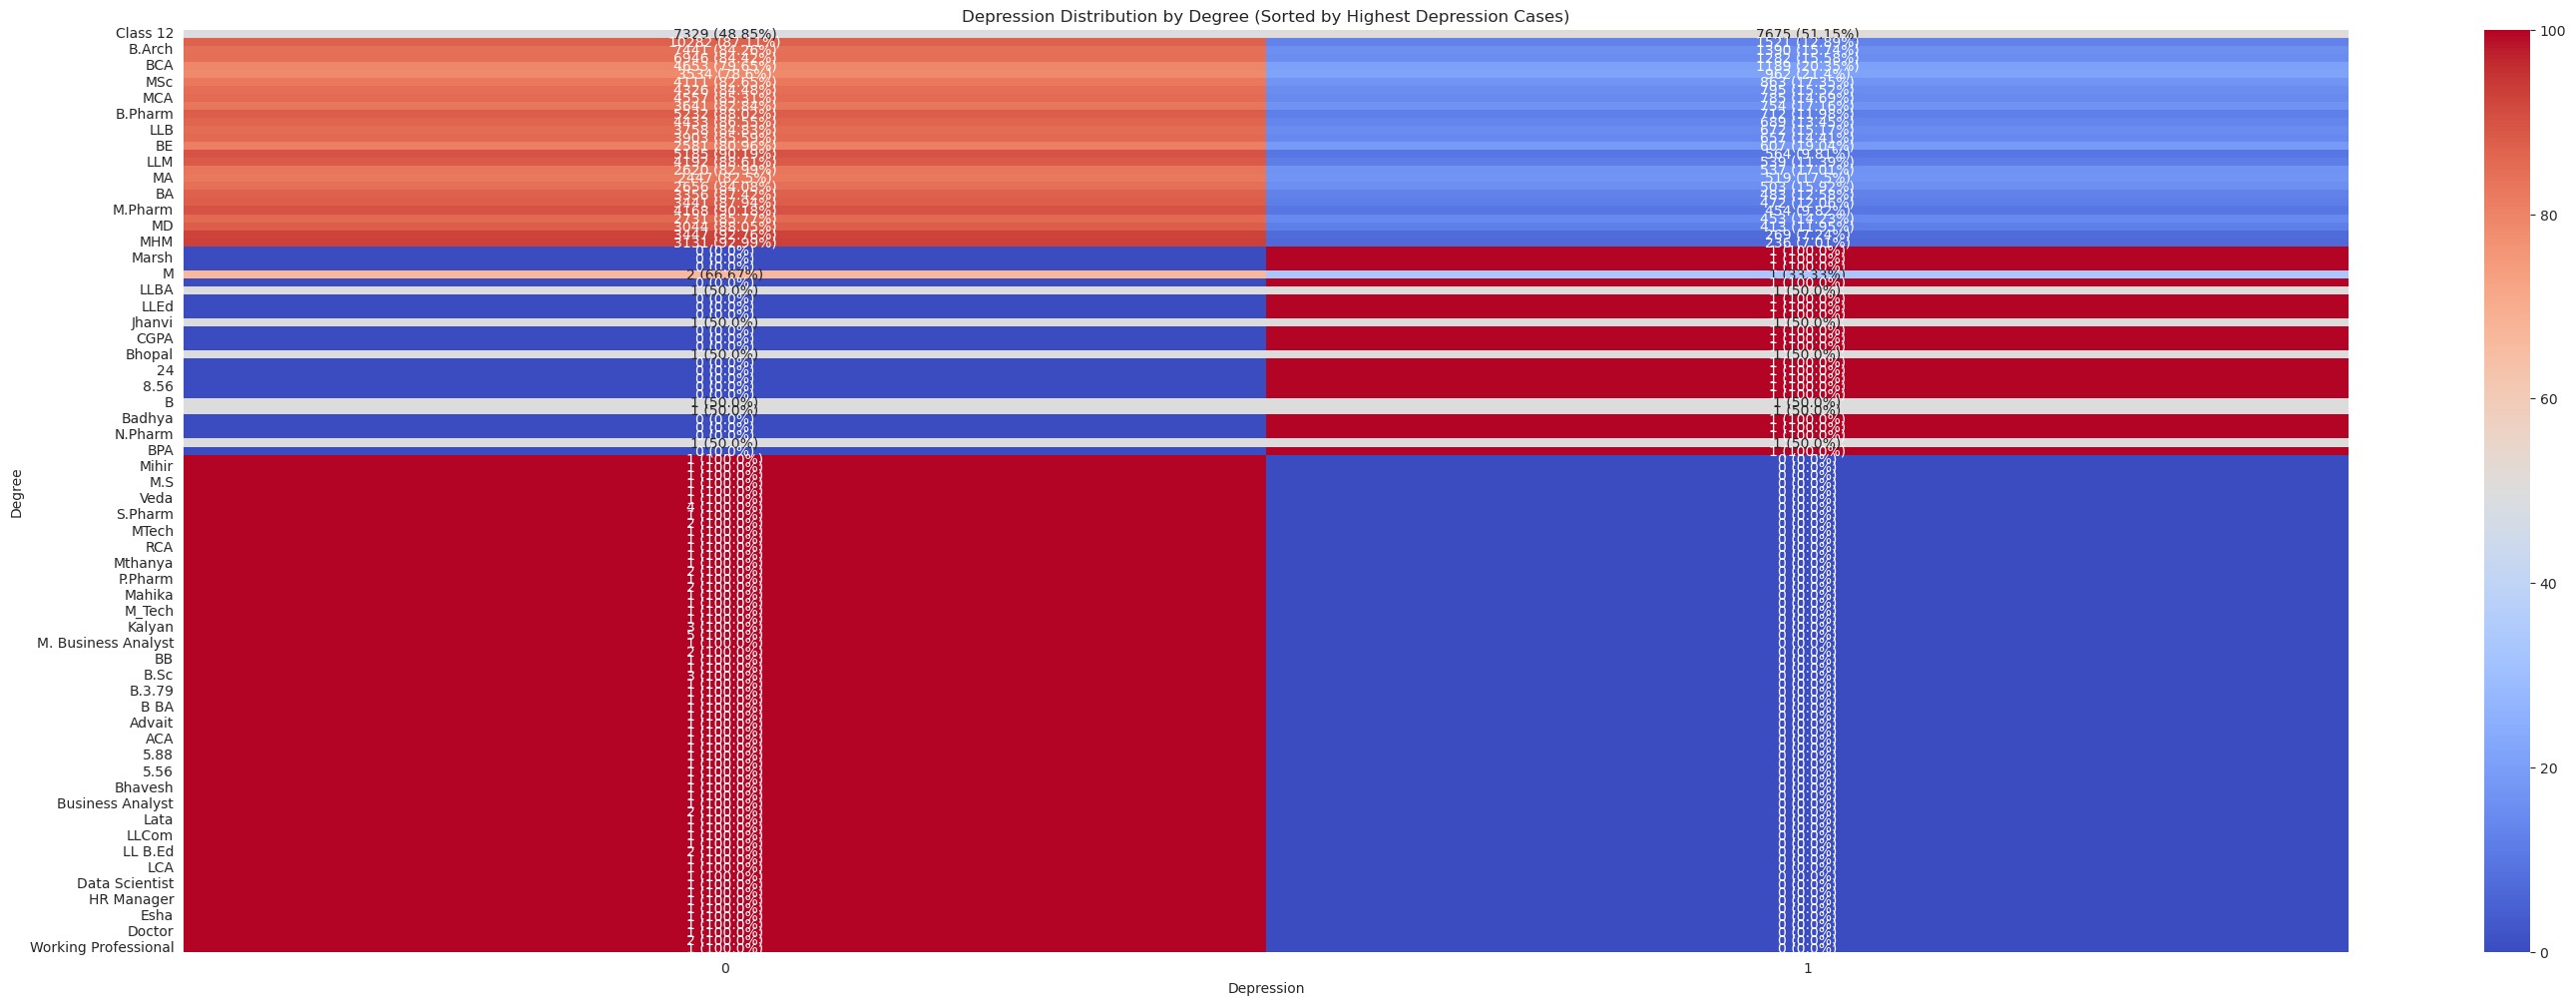

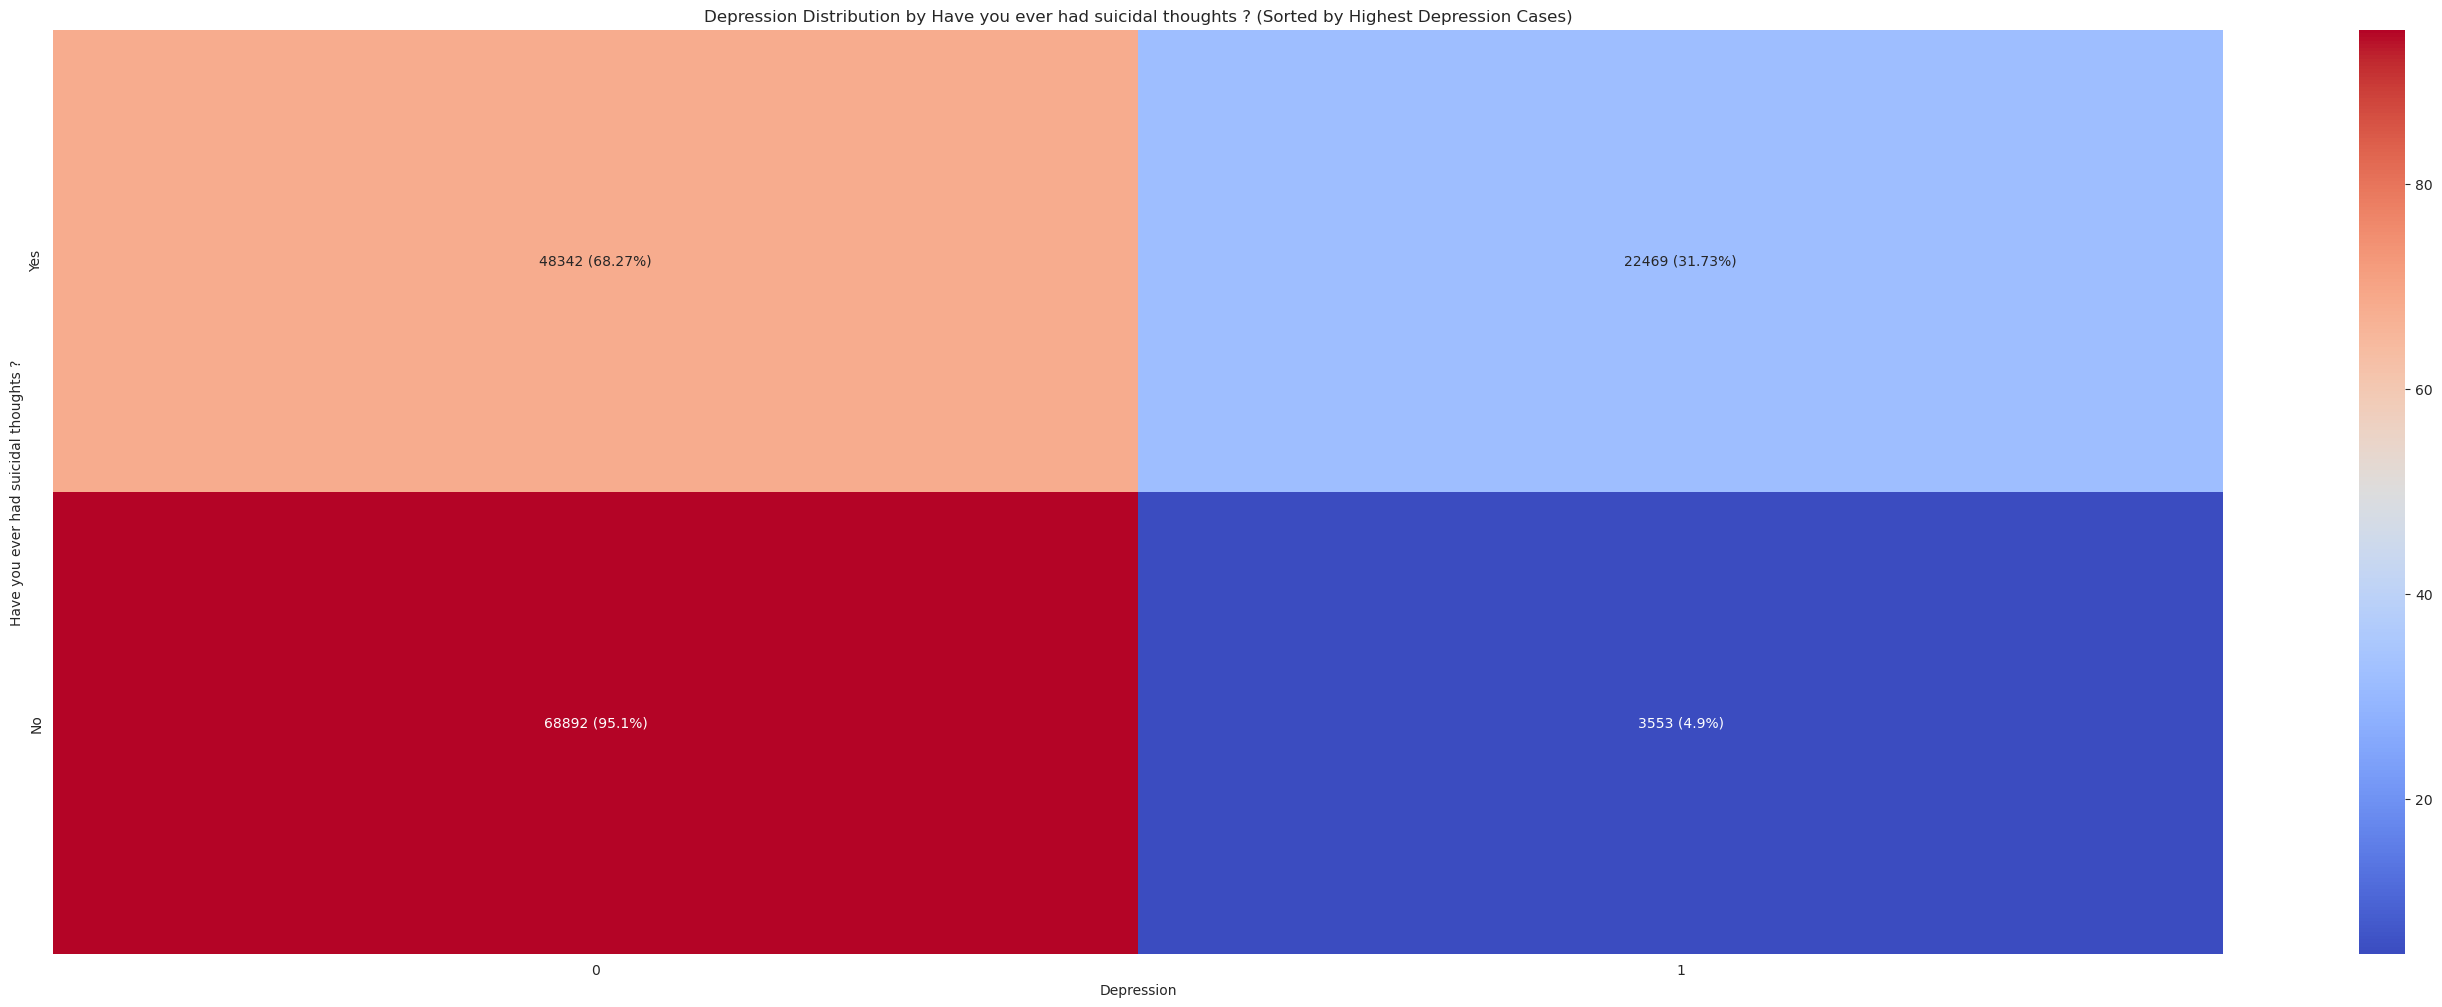

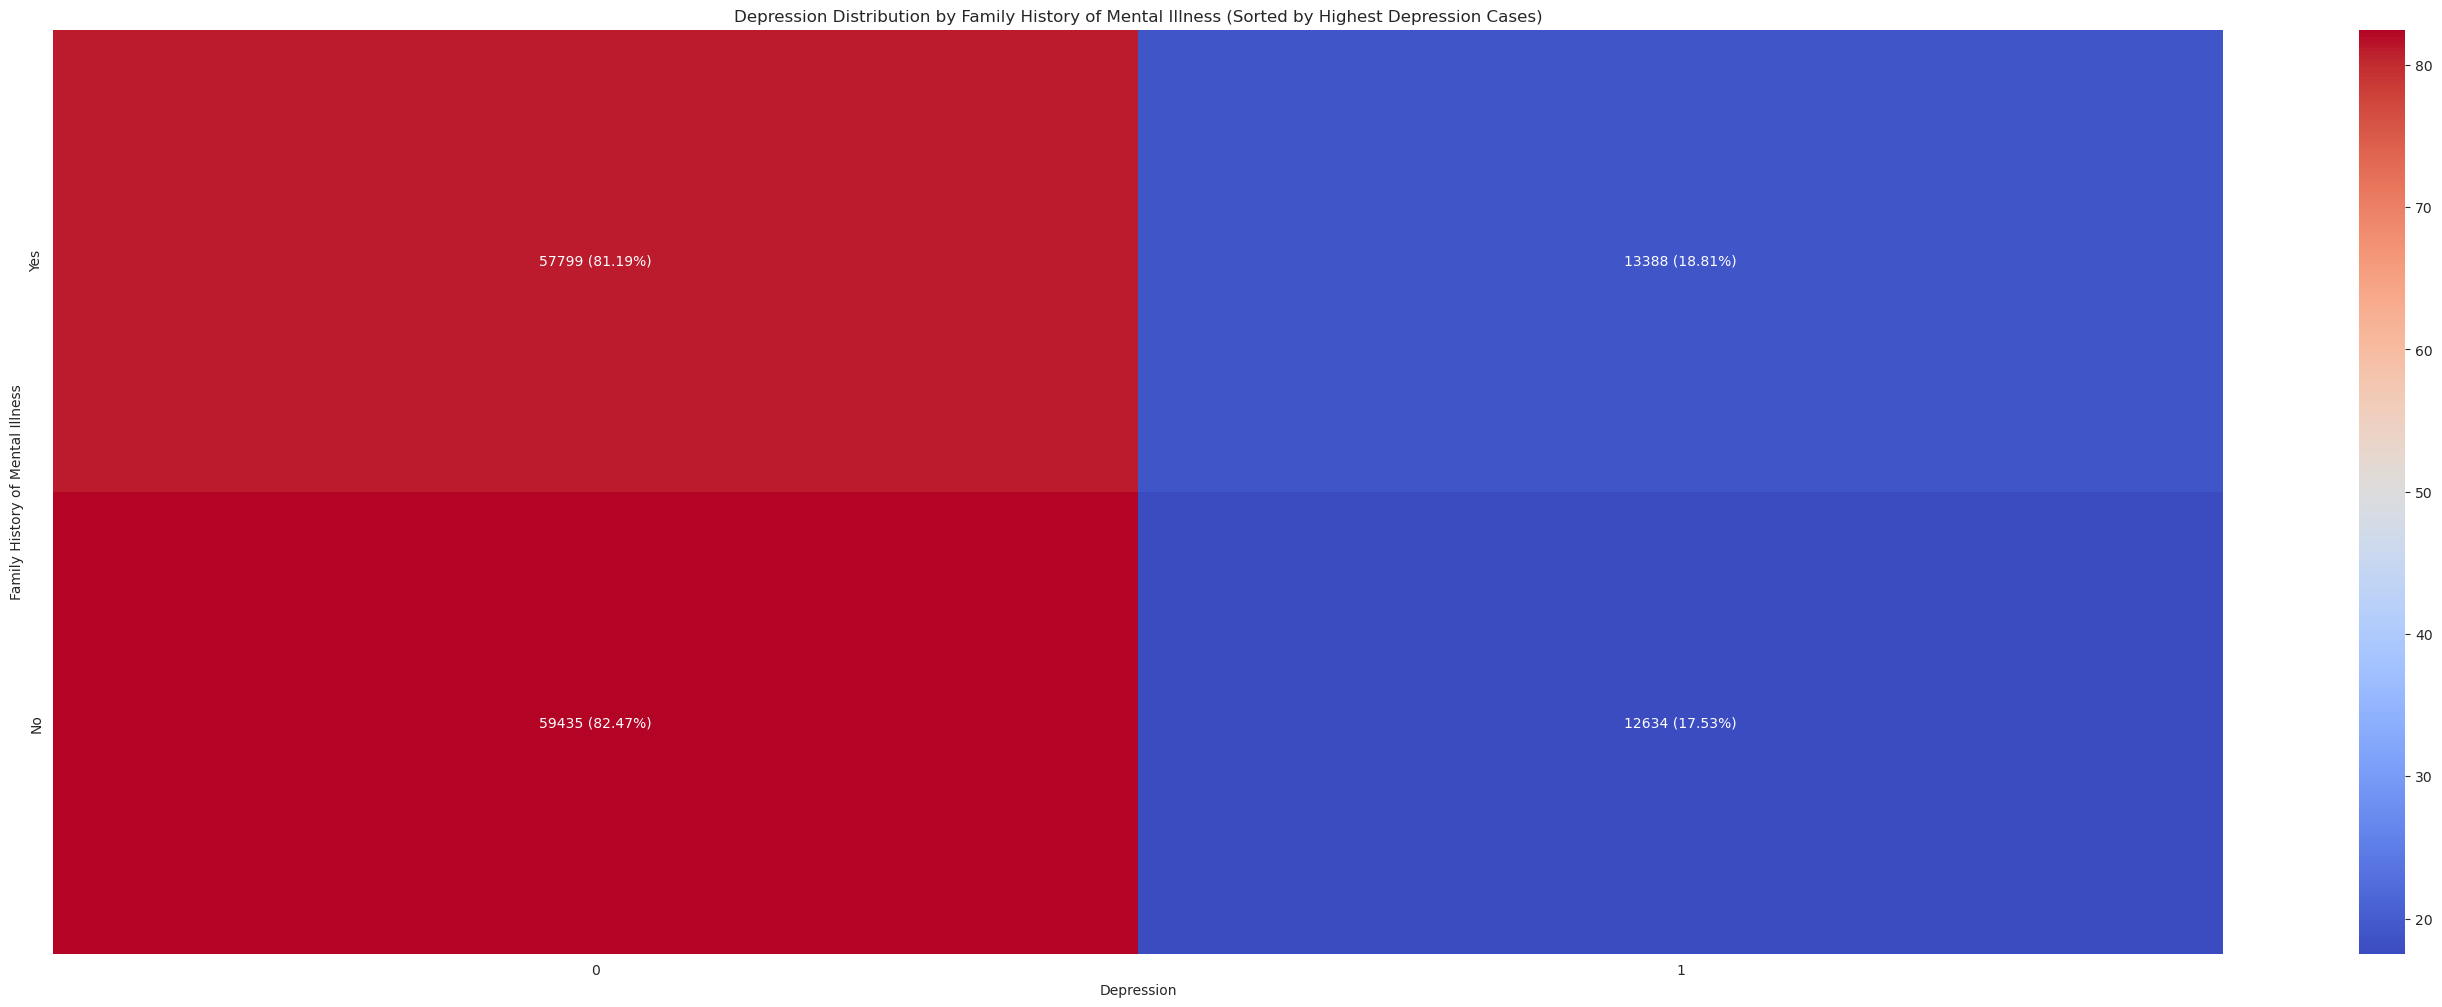

In [163]:
for col in categorical_features:
    plot_heatmap(train, col, 'Depression')

# Correlation Matrix Categorical Features

In [164]:
for col in train[categorical_features]:
    print(col)
    print(cramers_v(train[col], train["Depression"]))

Name
0.17498443171549424
Gender
0.007684116475338209
City
0.08543887191454455
Working Professional or Student
0.5189619945829453
Profession
0.11492329856920029
Sleep Duration
0.09172394947696044
Dietary Habits
0.15116199389526913
Degree
0.3038754890770927
Have you ever had suicidal thoughts ?
0.3478471244542771
Family History of Mental Illness
0.016321788573082485


# Merge categorical features

Index([], dtype='object', name='Working Professional or Student')


         Name  Gender   Age           City Working Professional or Student  \
0    Aaradhya  Female  49.0       Ludhiana            Working Professional   
1       Vivan    Male  26.0       Varanasi            Working Professional   
2      Yuvraj    Male  33.0  Visakhapatnam                         Student   
3      Yuvraj    Male  22.0         Mumbai            Working Professional   
4        Rhea  Female  30.0         Kanpur            Working Professional   
5        Vani  Female  59.0      Ahmedabad            Working Professional   
6      Ritvik    Male  47.0          Thane            Working Professional   
7     Rajveer    Male  38.0         Nashik            Working Professional   
8   Aishwarya  Female  24.0      Bangalore                         Student   
9      Simran  Female  42.0          Patna            Working Professional   
10    Utkarsh    Male  55.0         Rajkot            Working Professional   
11     Aahana  Female  51.0          Patna            Working Pr

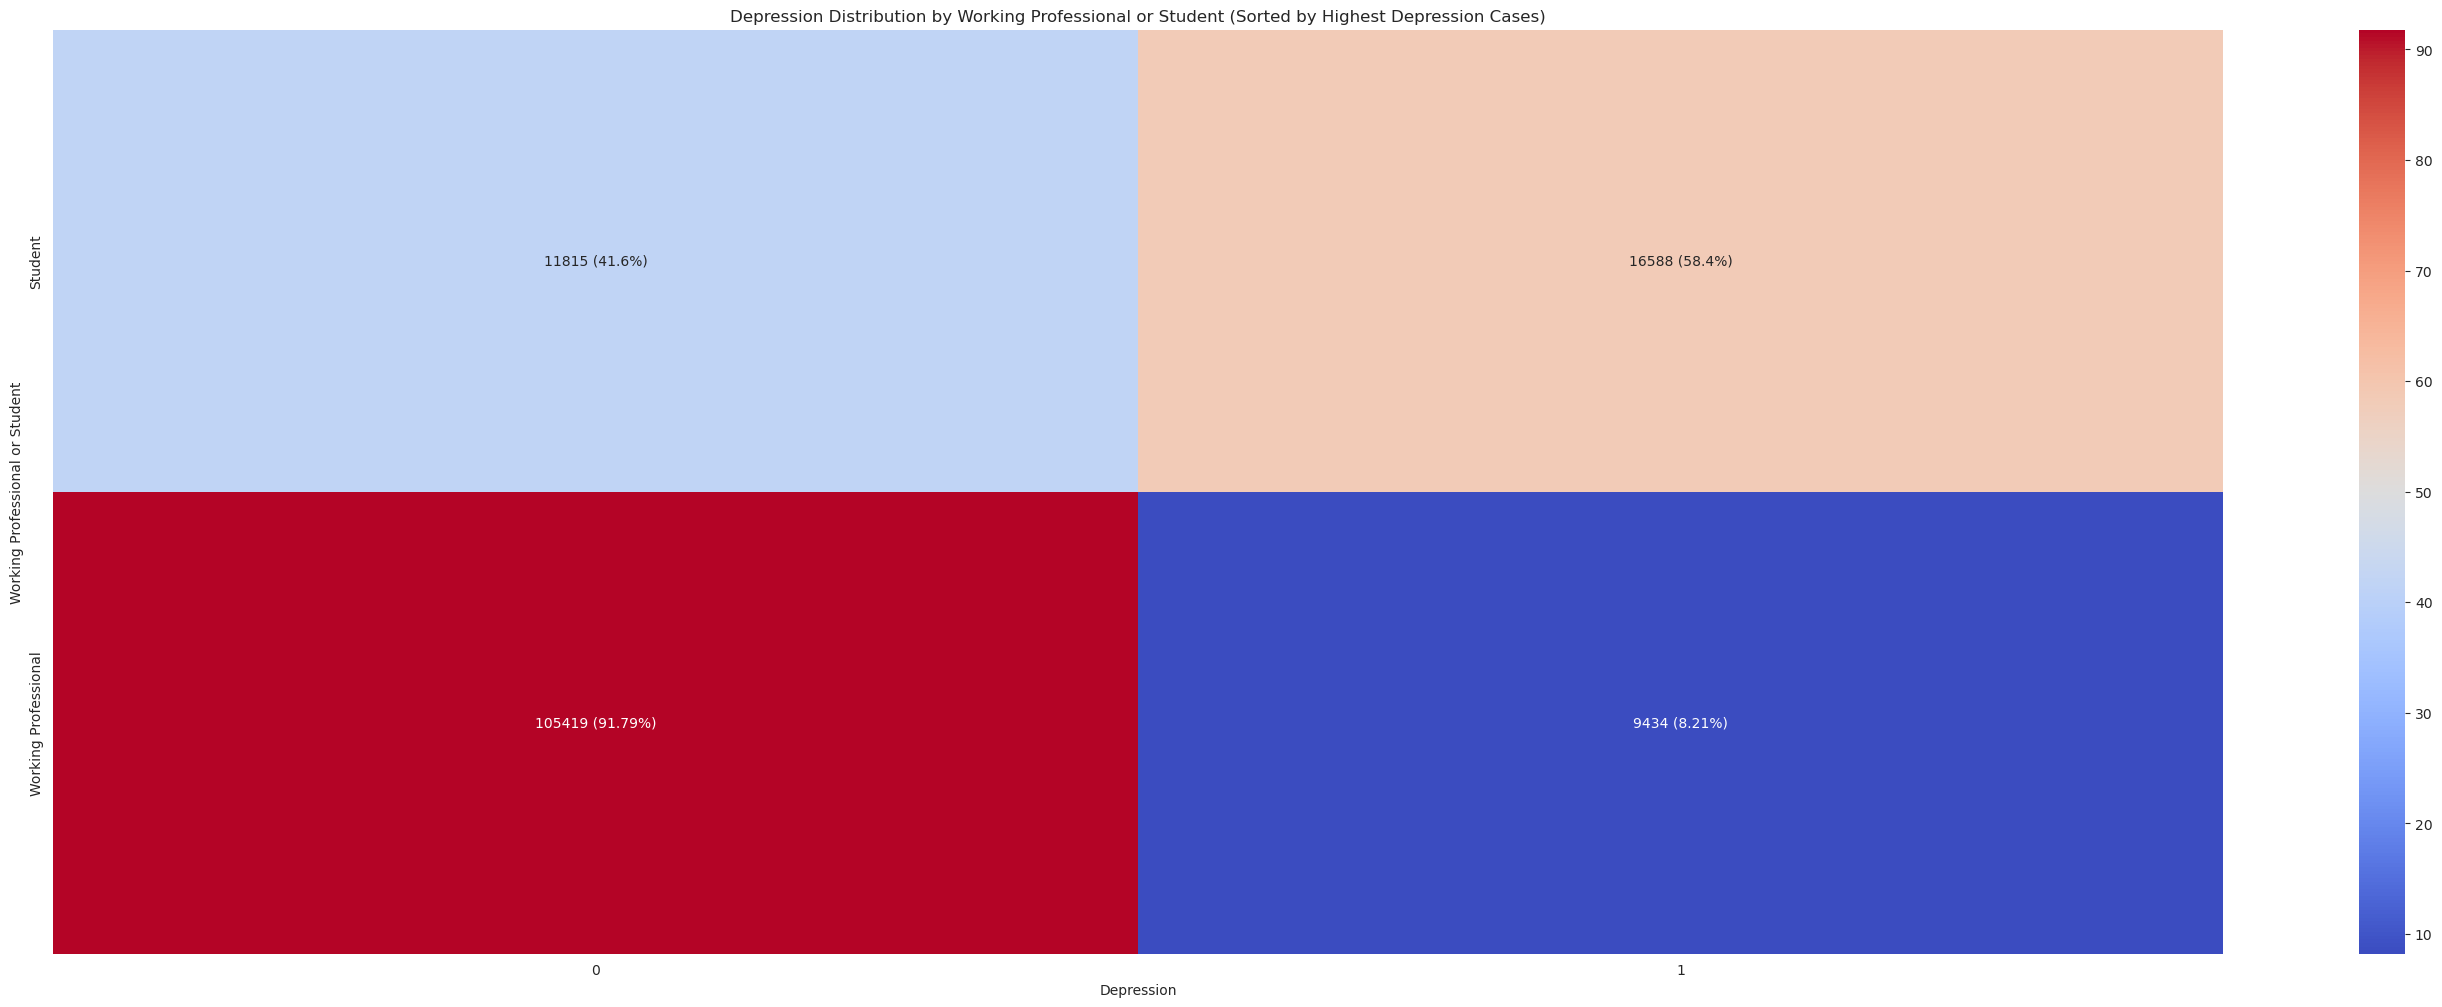

Index(['M.Arch', 'UX/UI Designer', 'B.Sc', 'Kalyan', 'M', 'BArch', 'MEd',
       'BPharm', 'P.Com', 'Jhanvi', 'LLBA', 'Degree', 'B', 'Bhopal', 'BEd',
       'Nalini', 'LL B.Ed', 'L.Ed', '5.88', 'HCA', 'Marsh', 'S.Arch', 'Pihu',
       'Lata', 'LHM', '8.56', 'Entrepreneur', 'Aarav', 'LLTech', 'BB',
       'M_Tech', 'B.Student', 'E.Tech', 'M.S', 'Navya', 'Mihir', 'RCA',
       'B B.Com', 'LCA', 'N.Pharm', 'Doctor', 'CGPA', 'LLEd', 'LLS', 'Esha',
       'Working Professional', 'Mthanya', 'B.3.79', 'K.Ed', 'Mahika', '24',
       'Vrinda', 'Brithika', 'ACA', 'Badhya', 'HR Manager', 'Unite', 'P.Pharm',
       'MPharm', 'Data Scientist', 'LL.Com', 'Business Analyst', 'H_Pharm',
       'Class 11', '20', 'S.Tech', 'Veda', 'BH', 'MPA', 'S.Pharm',
       'M. Business Analyst', 'Bhavesh', 'Brit', 'B.B.Arch', '7.06', 'B BA',
       '5.56', 'Ritik', 'B.03', '5.61', '0', 'Plumber', 'BPA', 'Vivaan',
       'MTech', '29', 'LLCom', 'Advait'],
      dtype='object', name='Degree')
         Name  Gender   

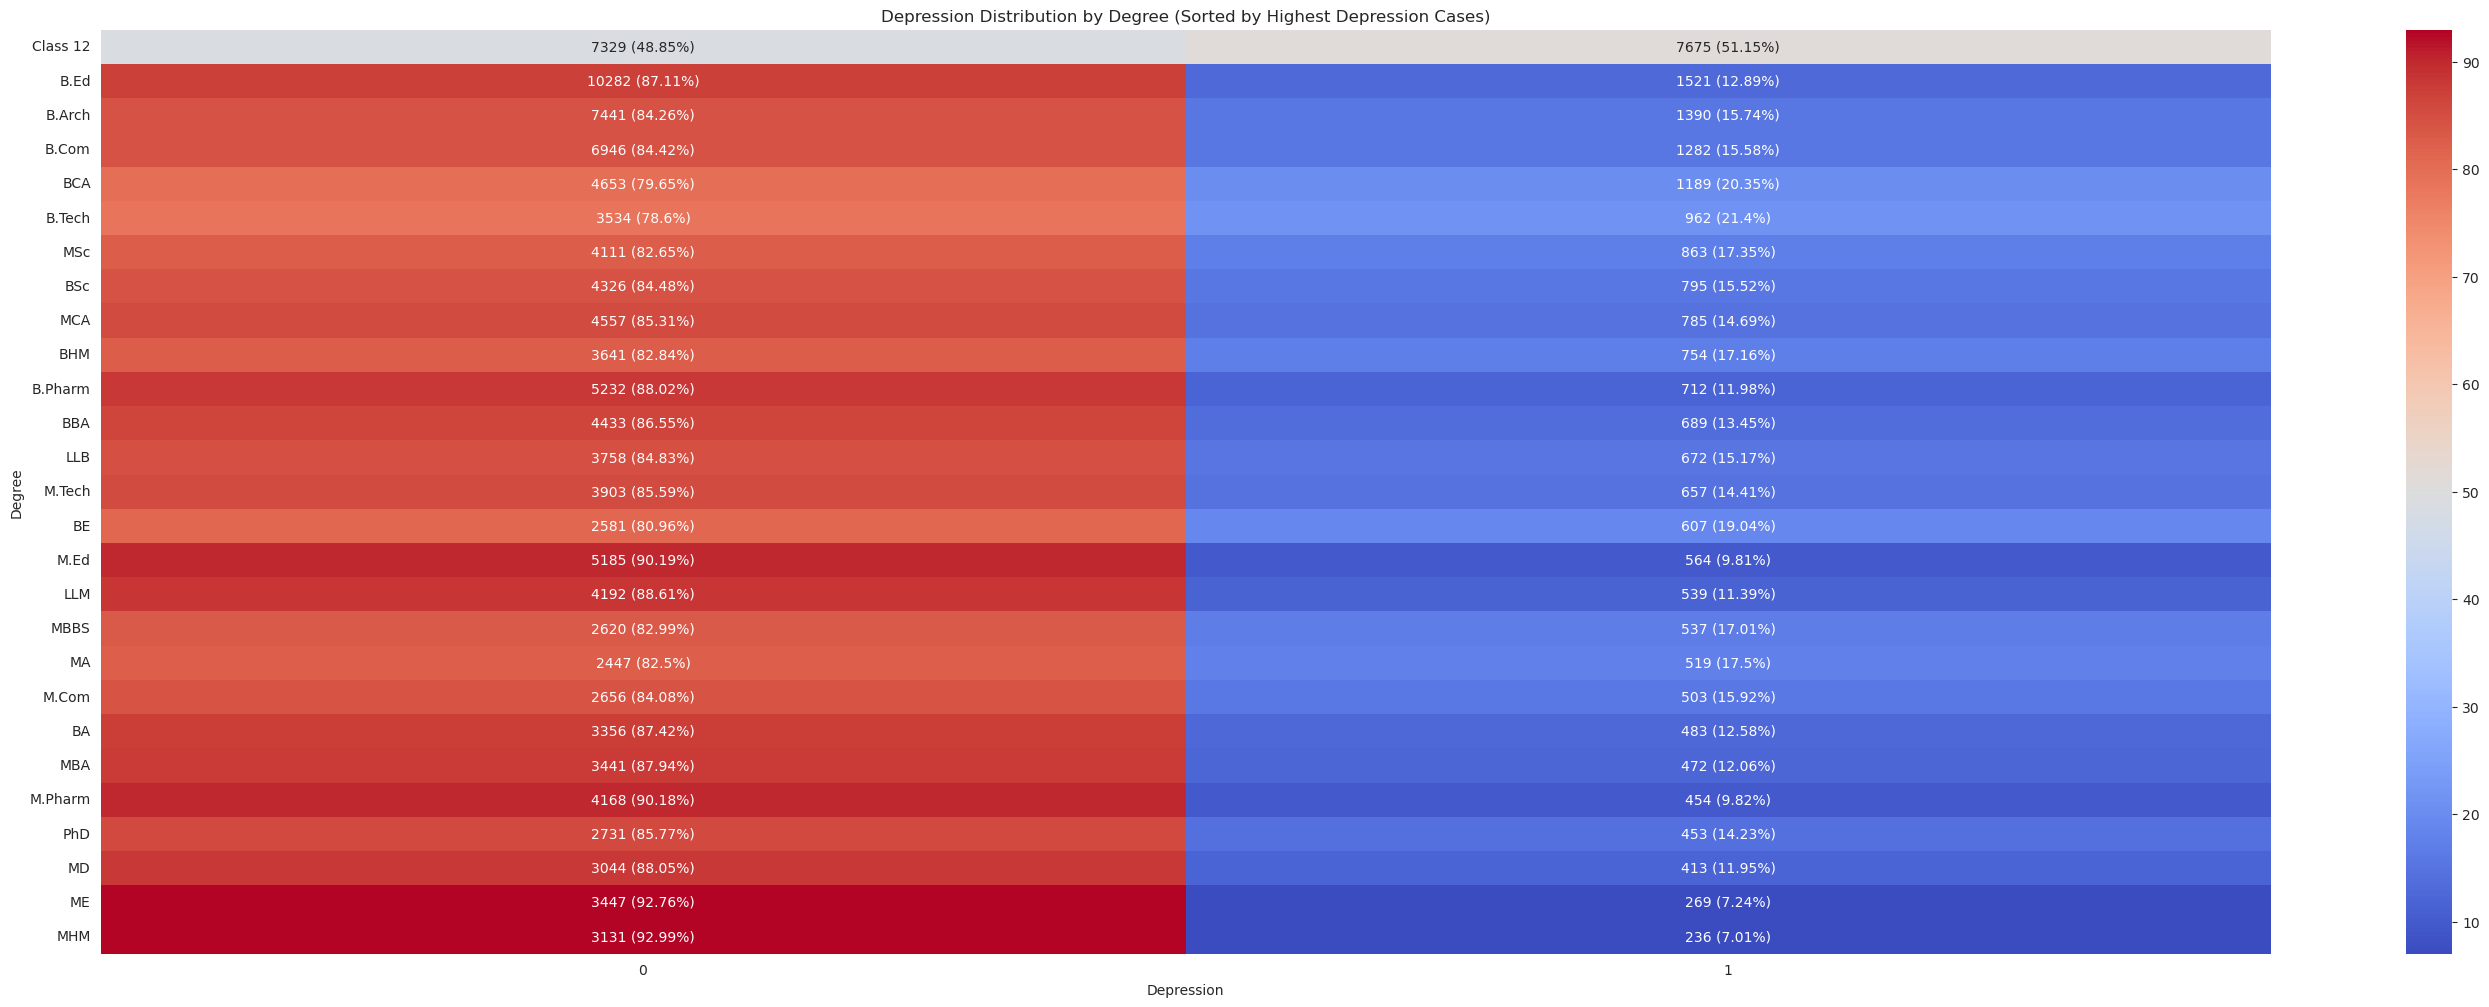

Index([], dtype='object', name='Have you ever had suicidal thoughts ?')
         Name  Gender   Age           City Working Professional or Student  \
0    Aaradhya  Female  49.0       Ludhiana            Working Professional   
1       Vivan    Male  26.0       Varanasi            Working Professional   
2      Yuvraj    Male  33.0  Visakhapatnam                         Student   
3      Yuvraj    Male  22.0         Mumbai            Working Professional   
4        Rhea  Female  30.0         Kanpur            Working Professional   
5        Vani  Female  59.0      Ahmedabad            Working Professional   
6      Ritvik    Male  47.0          Thane            Working Professional   
7     Rajveer    Male  38.0         Nashik            Working Professional   
8   Aishwarya  Female  24.0      Bangalore                         Student   
9      Simran  Female  42.0          Patna            Working Professional   
10    Utkarsh    Male  55.0         Rajkot            Working Professi

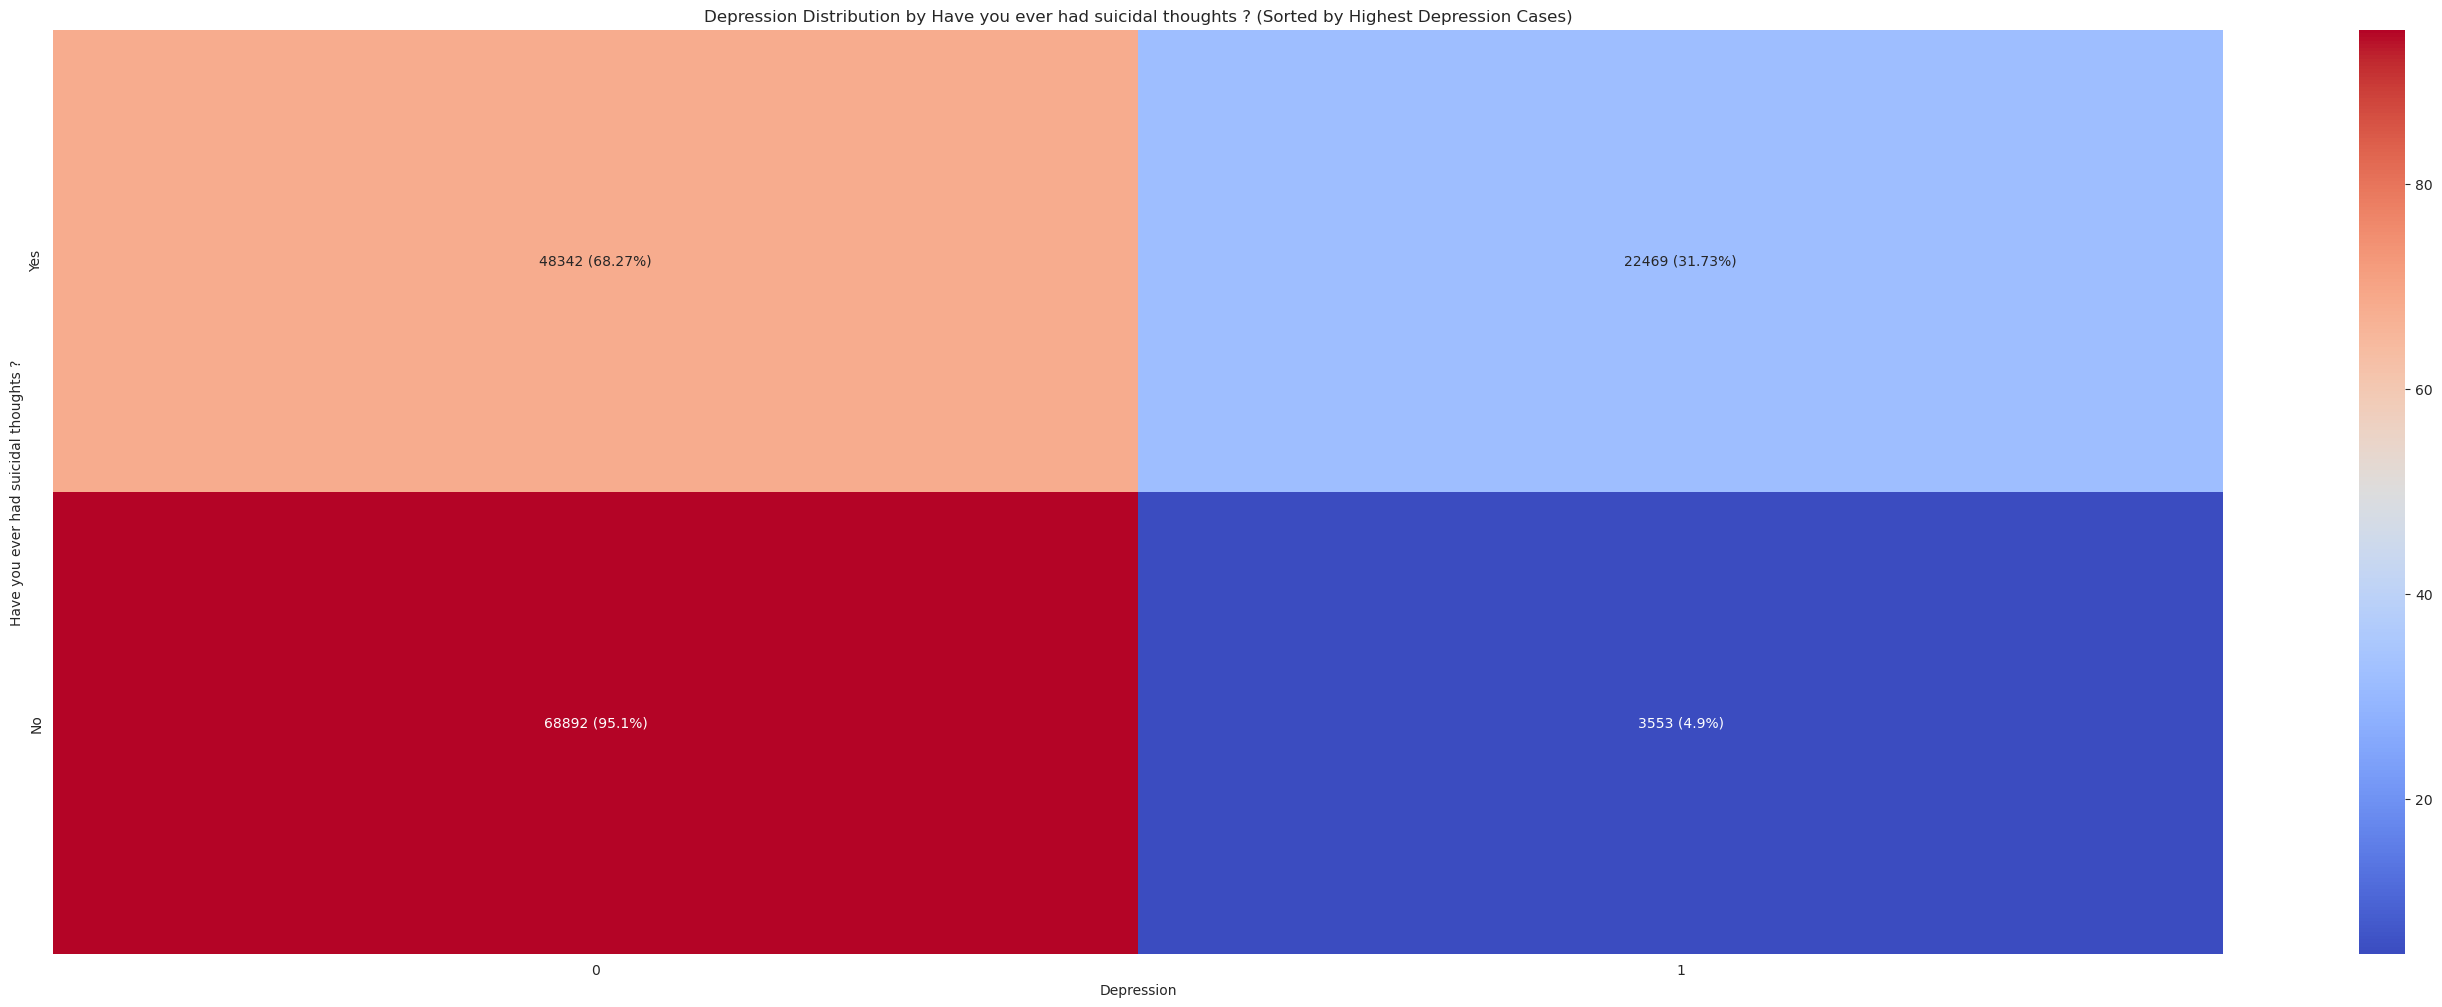

In [165]:
merge_features = ['Working Professional or Student', 'Degree', 'Have you ever had suicidal thoughts ?']
for col in merge_features:
    train = merge_rare_categories(train, col, 15)
    test = merge_rare_categories(test, col, 15)
    plot_heatmap(train, col, 'Depression')
    #plot_heatmap(test, col, 'Depression')

In [166]:
num_unique_degrees = train["Degree"].nunique()
unique_degrees = train["Degree"].unique()

In [167]:

print(f"Anzahl der einzigartigen Kategorien in der Spalte 'Degree': {num_unique_degrees}")
print(f"Einzigartige Kategorien in der Spalte 'Degree': {unique_degrees}")

Anzahl der einzigartigen Kategorien in der Spalte 'Degree': 27
Einzigartige Kategorien in der Spalte 'Degree': ['BHM' 'LLB' 'B.Pharm' 'BBA' 'MCA' 'MD' 'BSc' 'ME' 'B.Arch' 'BCA' 'BE'
 'MA' 'B.Ed' 'B.Com' 'MBA' 'M.Com' 'MHM' 'BA' 'Class 12' 'M.Tech' 'PhD'
 'M.Ed' 'MSc' 'B.Tech' 'LLM' 'MBBS' 'M.Pharm' None nan]


In [168]:
train.drop(columns=['CGPA'], inplace=True)
train.drop(columns=['Age'], inplace=True)
train.drop(columns=['Name'], inplace=True)
train.drop(columns=['Gender'], inplace=True)
train.drop(columns=['City'], inplace=True)
train.drop(columns=['Profession'], inplace=True)
train.drop(columns=['Sleep Duration'], inplace=True)
train.drop(columns=['Dietary Habits'], inplace=True)
train.drop(columns=['Family History of Mental Illness'], inplace=True)
train.drop(columns=['Academic Pressure'], inplace=True) # not sure about that

test.drop(columns=['CGPA'], inplace=True)
test.drop(columns=['Age'], inplace=True)
test.drop(columns=['Name'], inplace=True)
test.drop(columns=['Gender'], inplace=True)
test.drop(columns=['City'], inplace=True)
test.drop(columns=['Profession'], inplace=True)
test.drop(columns=['Sleep Duration'], inplace=True)
test.drop(columns=['Dietary Habits'], inplace=True)
test.drop(columns=['Family History of Mental Illness'], inplace=True)
test.drop(columns=['Academic Pressure'], inplace=True) # not sure about that

In [169]:
num_unique_degrees = train["Degree"].nunique()
unique_degrees = train["Degree"].unique()

print(f"Anzahl der einzigartigen Kategorien in der Spalte 'Degree': {num_unique_degrees}")
print(f"Einzigartige Kategorien in der Spalte 'Degree': {unique_degrees}")

Anzahl der einzigartigen Kategorien in der Spalte 'Degree': 27
Einzigartige Kategorien in der Spalte 'Degree': ['BHM' 'LLB' 'B.Pharm' 'BBA' 'MCA' 'MD' 'BSc' 'ME' 'B.Arch' 'BCA' 'BE'
 'MA' 'B.Ed' 'B.Com' 'MBA' 'M.Com' 'MHM' 'BA' 'Class 12' 'M.Tech' 'PhD'
 'M.Ed' 'MSc' 'B.Tech' 'LLM' 'MBBS' 'M.Pharm' None nan]


After dropping a lot of features. There is a significant loss of categories at Degree! From 27 to 16!!!!

## Numeric Feature Attributes

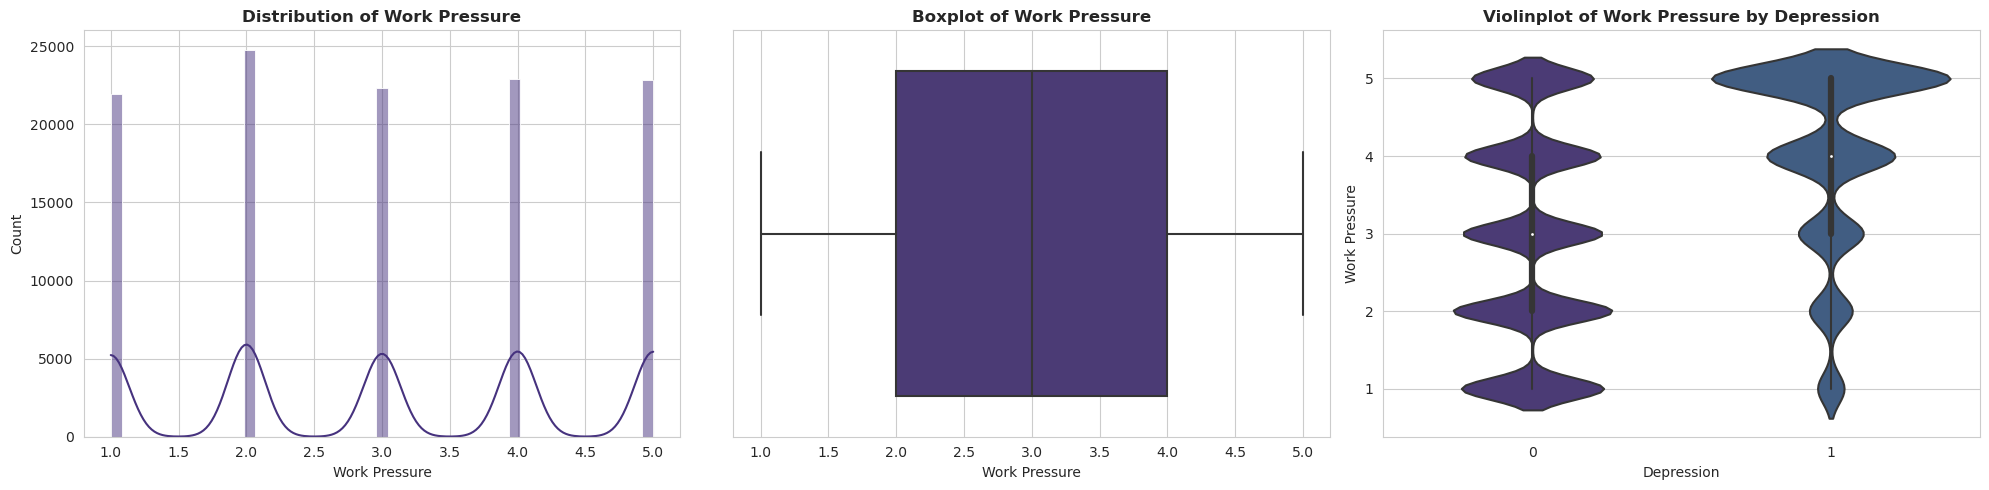

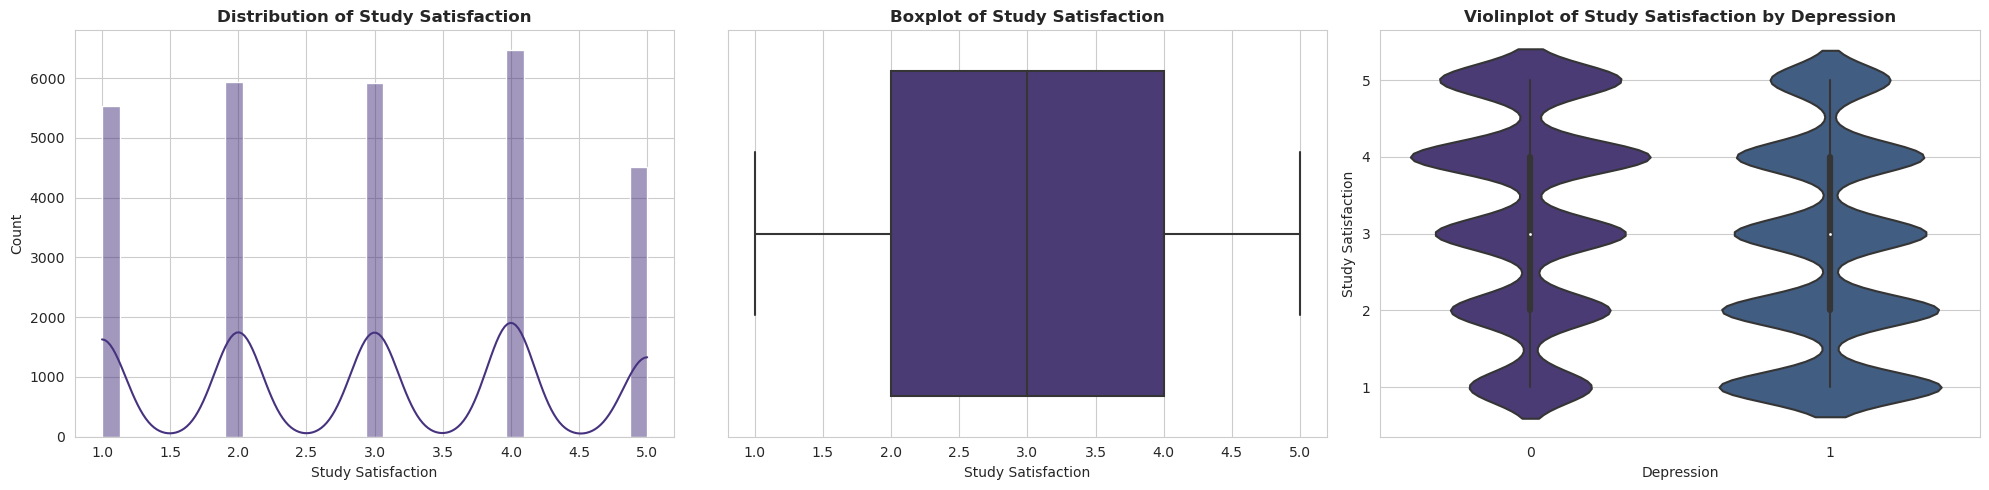

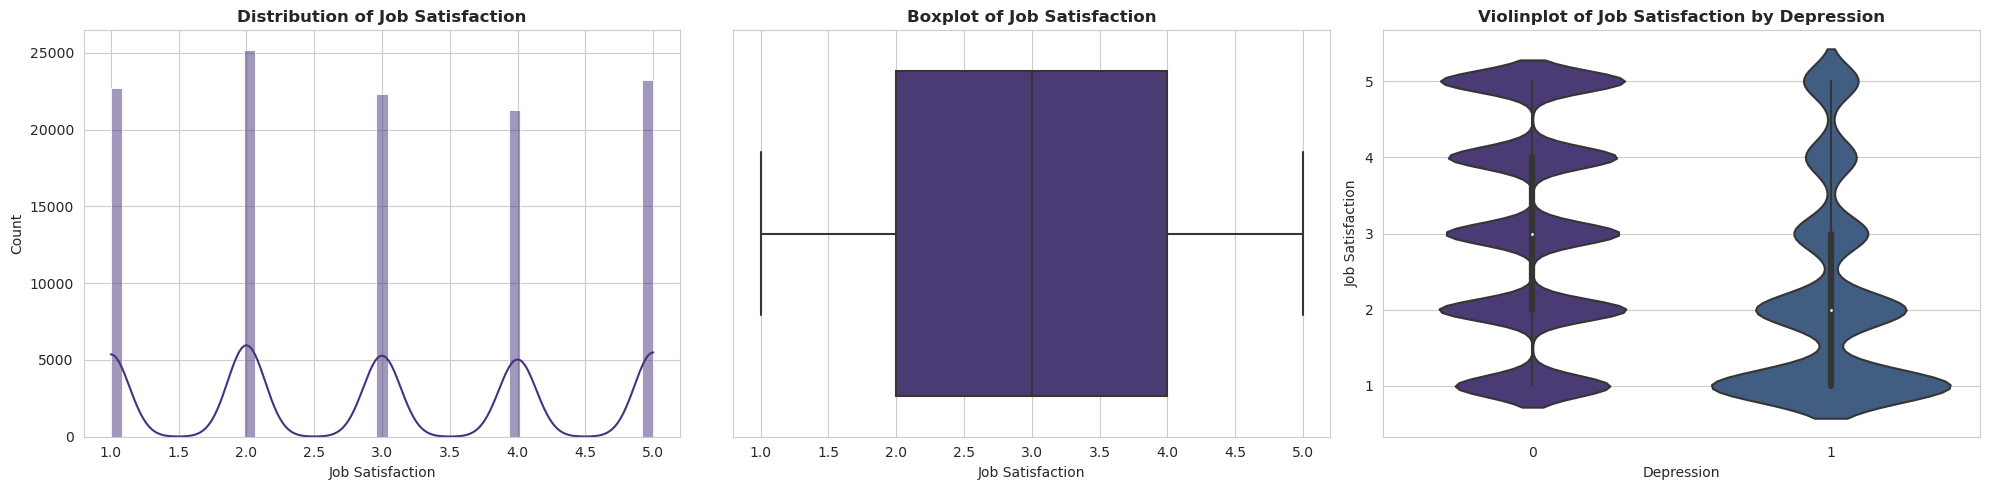

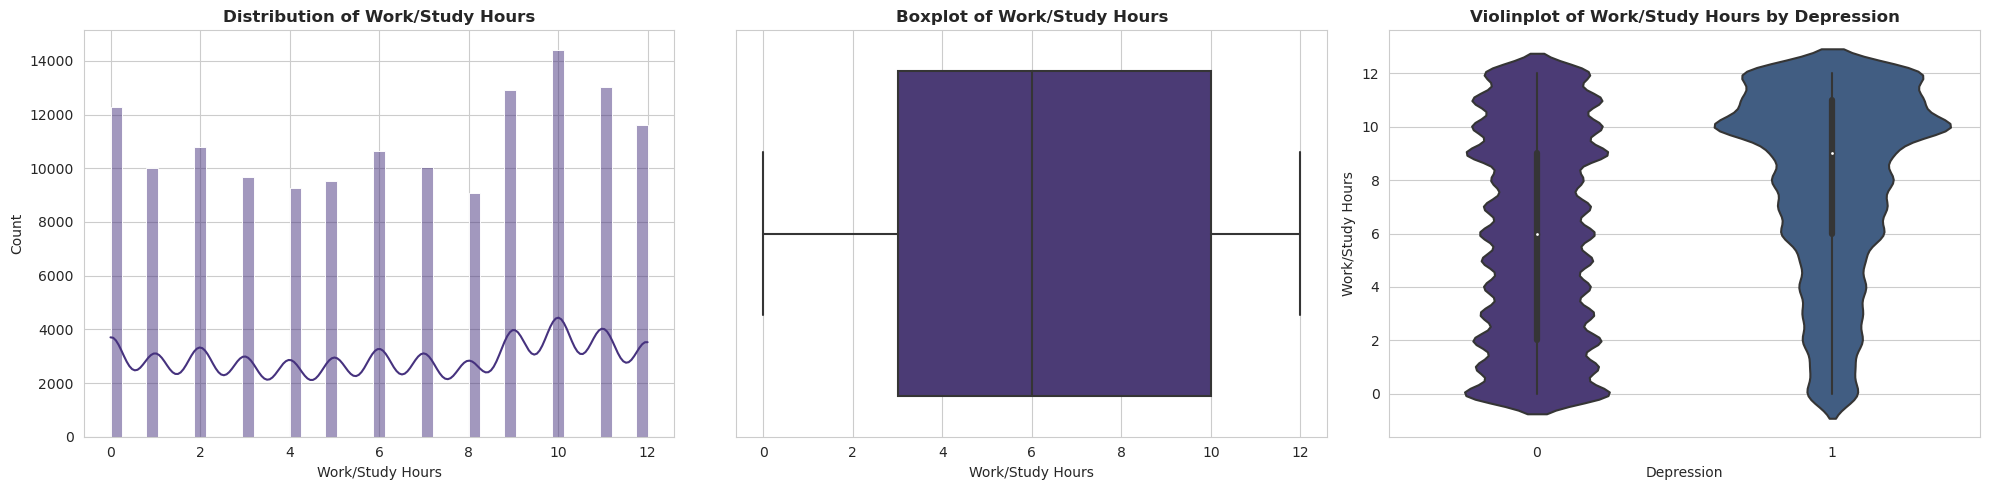

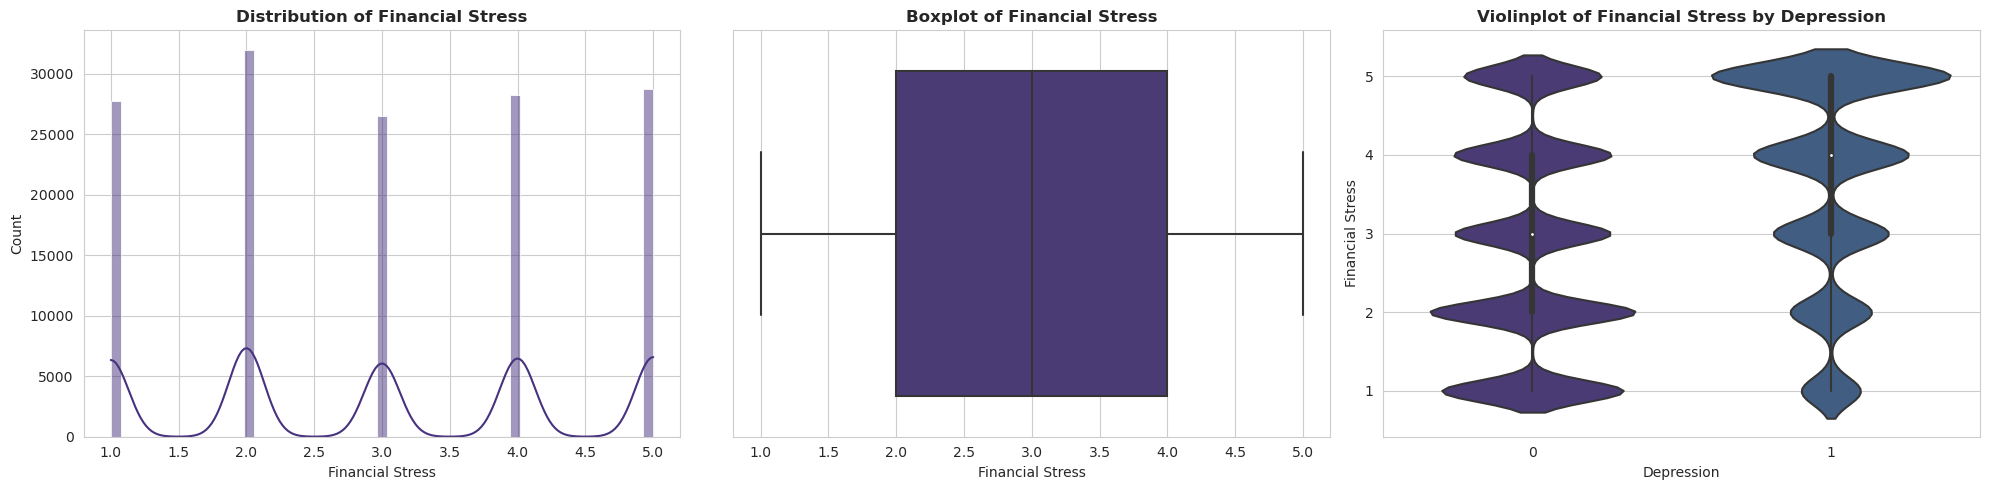

## Categorical Feature Attributes

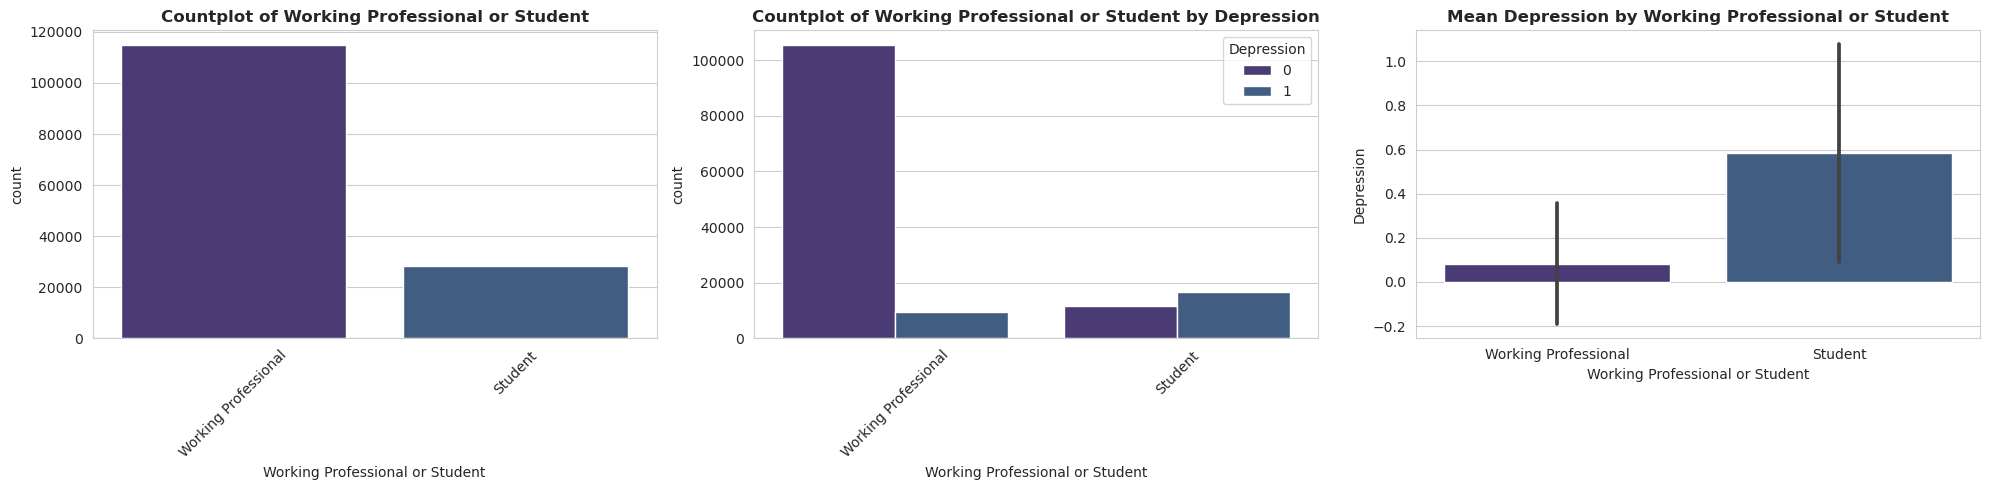

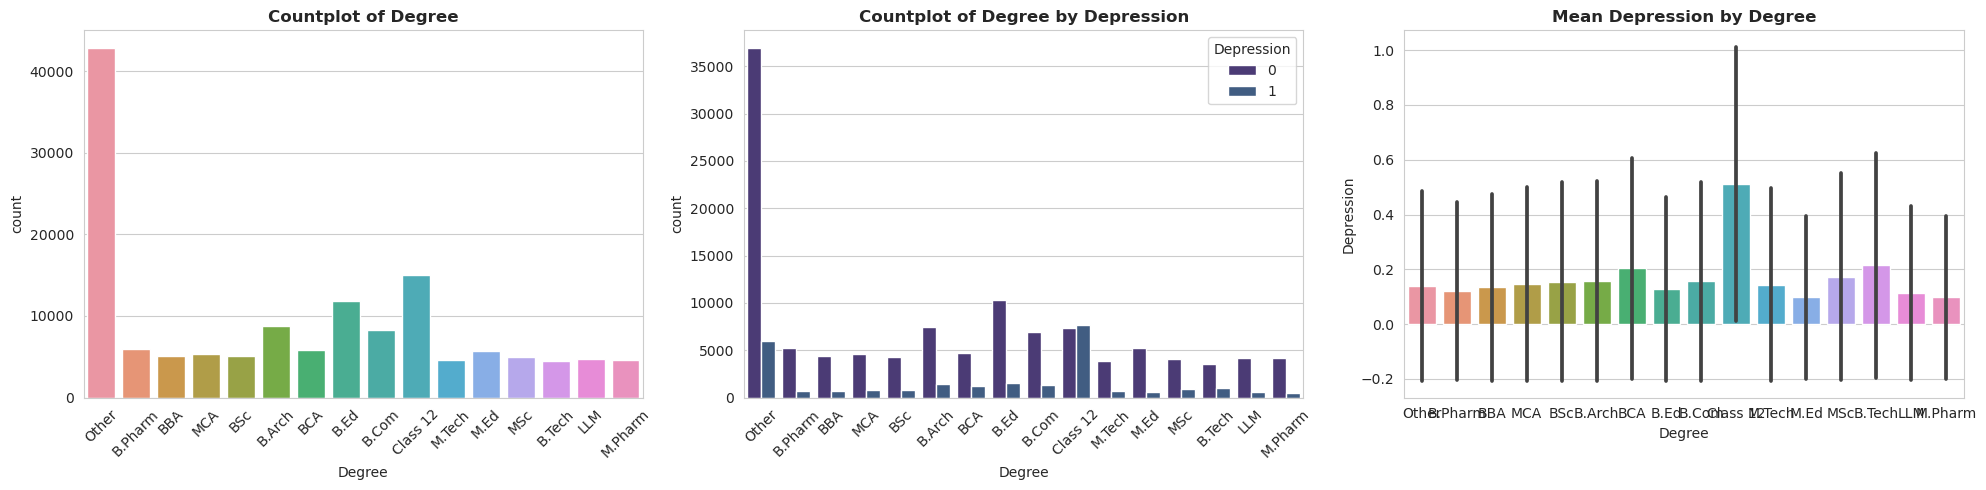

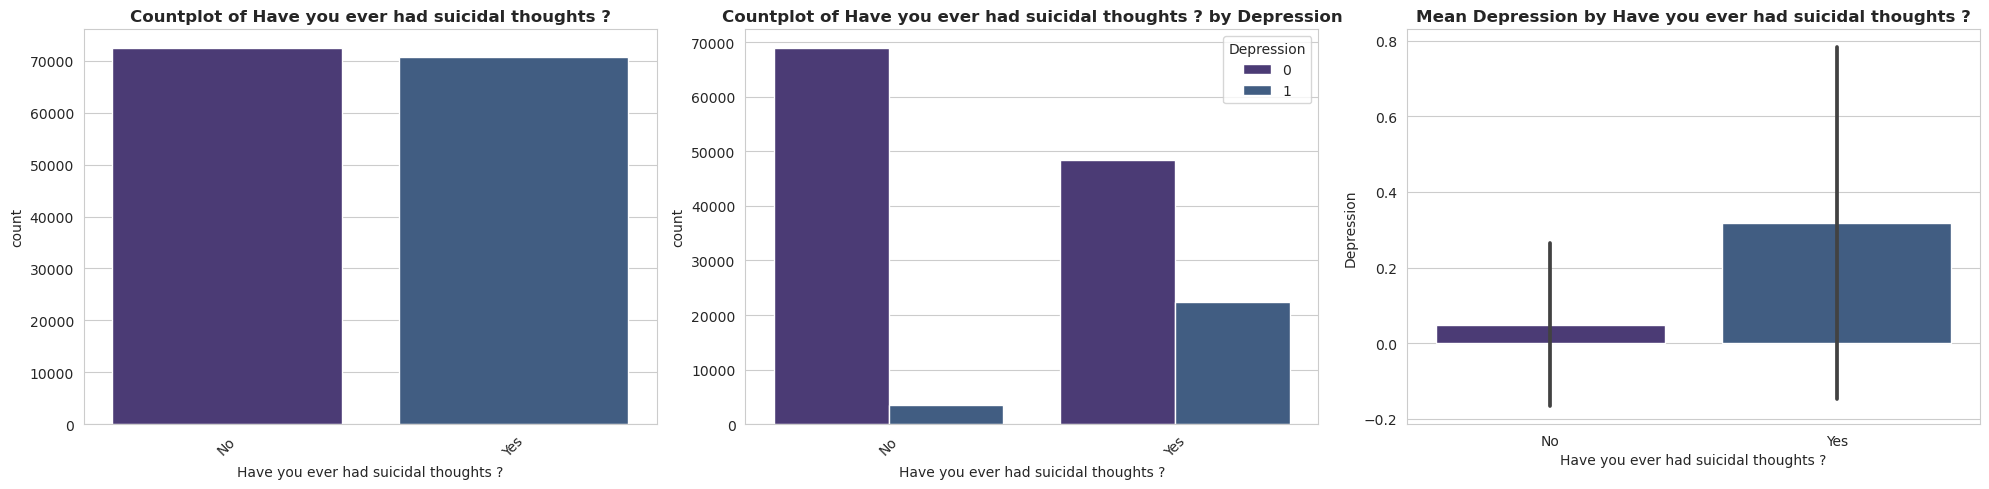

In [170]:
visualize_feature_attributes(train, target="Depression")

# Analyze
## Numerical Features
- Age (-0,56): Most people are depressed between 19-50 years. Biggest peak is at age 19. Data is good distributed. No missing data.
- Academic Pressure (0,48), correlates a lot. Unfortunaly a lot of missing data, 80% are missing data!
- Work Pressure (0,22). if you have stress at work there is chance that you are also depressed, 20% missing data
- Delete: CPGA (0,02), it is good distributed there is not a really hint about that to depression. Will delete that feature.
- Prob Delete: Study Satisfaction (-0,17), 114k missing data, not sure if deleting is a good idea. Probably will delete this as well.
- Job Satisfaction (-0,17), 28k missing data, we can try to use it.
- Work/Study Hours (0,19), no missing data, you can see it clear if you work a lot you have a chance to be depressed.
- Financial Stress (0,23), If you are facing a lot of Financial Stress, there is chance you are as well depresssed.


## Categorical Features
- Delete: Name (+0,17), not sure why it is correlating? Is that a family thing that people who have the same name.
- Delete: Gender (+ 0,007) doesn't make sense to use it.
- Delete: City (+0,08) doesn't make sense to use it.
- Working Professional or Student (+0,52), 0 missing data. Should use it.
- Delete: Profession (+0.11), 36.000 missing data, 
- Delete: Sleep Duration (+0,09), 0 missing data
- Delete: Dietary Habits (+0,15), ...
- Degree (+0,3), There a lot about that Class 12(>15.000 data samples!, 50% depressed), Bachelor of Computer Application is at second place xD
- Have you ever had suicidal thoughts (+0,35), 0 missing signals, 
- Delete: Family History of Mental Illness (+0.16). That fact is super interesting. There are actually studies showing that if parents face mental illness, their children also have a higher risk than usual.

I delete some of the sub categories features (e.g. ACA just one data sampel). Didn't detect outliers.

# Save CSV Files as Kaggle Datasets

In [171]:
if KAGGLE_ENV:
    train.to_csv('/kaggle/input/s4-e11-train-concat/s4-e11-train-concat.csv', index=False)
else:
    train.to_csv('../kaggle/input/' + '/s4-e11-train-concat/s4-e11-train-concat.csv', index=False)

In [172]:
# save test data set
if KAGGLE_ENV:
    test.to_csv('/kaggle/input/s4-e11-test-concat/s4-e11-test-concat.csv', index=False)
else:
    test.to_csv( '../kaggle/input/' + '/s4-e11-test-concat/s4-e11-test-concat.csv', index=False)

In [173]:
train.head()

Working Professional or Student  Work Pressure  Study Satisfaction  \
0            Working Professional            5.0                 NaN   
1            Working Professional            4.0                 NaN   
2                         Student            NaN                 2.0   
3            Working Professional            5.0                 NaN   
4            Working Professional            1.0                 NaN   

   Job Satisfaction   Degree Have you ever had suicidal thoughts ?  \
0               2.0    Other                                    No   
1               3.0    Other                                   Yes   
2               NaN  B.Pharm                                   Yes   
3               1.0      BBA                                   Yes   
4               1.0      BBA                                   Yes   

   Work/Study Hours  Financial Stress  Depression  
0               1.0               2.0           0  
1               7.0               3.0           1  
2               3.0               1.0           1  
3              10.0               1.0           1  
4               9.0               4.0           0

In [174]:
test.head()

Working Professional or Student  Work Pressure  Study Satisfaction  \
0            Working Professional            2.0                 NaN   
1            Working Professional            2.0                 NaN   
2            Working Professional            4.0                 NaN   
3                         Student            NaN                 1.0   
4            Working Professional            5.0                 NaN   

   Job Satisfaction  Degree Have you ever had suicidal thoughts ?  \
0               5.0     LLB                                    No   
1               4.0    B.Ed                                    No   
2               1.0  B.Arch                                   Yes   
3               NaN     BSc                                   Yes   
4               5.0     BCA                                   Yes   

   Work/Study Hours  Financial Stress  
0               9.0               3.0  
1               6.0               4.0  
2              12.0               4.0  
3              10.0               4.0  
4               3.0               4.0